# Bayesian regression using UltraNest

Report any errors to Joris De Ridder.

## Imports

In [1]:
import sys

In [2]:
import numpy as np
import scipy as sp
import pandas as pd

In [3]:
from scipy.special import expit                    # logistic sigmoid function: expit(x) = 1/(1+exp(-x))

In [4]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [5]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt

In [6]:
import ultranest
from ultranest.plot import cornerplot, traceplot, PredictionBand

In [7]:
import arviz as az

In [8]:
import xarray as xr

In [9]:
import corner

## Matplotlib font sizes

In [55]:
plt.rc('font',   size=14)          # controls default text sizes
plt.rc('axes',   titlesize=14)     # fontsize of the axes title
plt.rc('axes',   labelsize=14)     # fontsize of the x and y labels
plt.rc('xtick',  labelsize=14)     # fontsize of the tick labels
plt.rc('ytick',  labelsize=14)     # fontsize of the tick labels
plt.rc('legend', fontsize=14)      # legend fontsize
plt.rc('figure', titlesize=14)     # fontsize of the figure title

## Links to documentation on the web

* [UltraNest documentation](https://johannesbuchner.github.io/UltraNest/index.html)

## Contents

* [Basic linear regression [UltraNest]](#Basic-linear-regression-with-UltraNest)
* [Robust regression using a Student's T-distribution [UltraNest]](#Robust-regression-using-a-StudentT-likelihood-with-UltraNest)
* [Robust regression using the Hogg et al. approach [UltraNest]](#Robust-regression-using-the-Hogg-approach-with-UltraNest)
* [Piecewise linear regression [UltraNest]](#Piecewise-linear-regression-with-UltraNest)
* [Uncertainties in y and x [UltraNest]](#Uncertainties-in-y-and-x-with-UltraNest)
* [Fitting a distribution to a dataset [UltraNest]](#Modeling-a-distribution-for-a-dataset-with-UltraNest)
* [Binomial logistic regression [UltraNest]](#Fitting-a-logit-model-with-UltraNest)
* [Multinomial logistic regression [Ultranest]](#A-multinomial-logistic-model-with-UltraNest)
* [Modeling a fraction with Beta [UltraNest]](#Modeling-a-fraction-with-the-Beta-distribution-with-UltraNest)
* [Modeling counts with Poisson [UltraNest]](#Modeling-counts-with-Poisson-with-UltraNest)
* [Zero-truncated Poisson model [UltraNest]](#A-zero-truncated-Poisson-model-with-UltraNest)

## Basic linear regression with UltraNest

#### A synthetic dataset:

In [11]:
rng = np.random.default_rng(14)

N = 50
theta0 = 1
theta1 = 2                   # ~ tan(1.107)
sigma = 0.3

xobs = np.linspace(0, 1, N)
yobs = theta0 + theta1 * xobs + rng.normal(0.0, sigma, N)

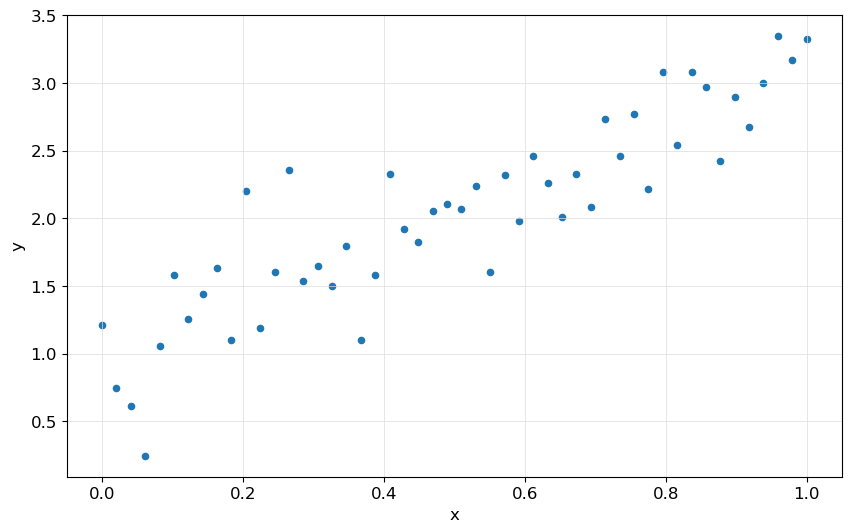

In [12]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.scatter(xobs, yobs, s=20)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

#### The Bayesian model

Our Bayesian model:

$\mu = \theta_0+\theta_1 x$

$\theta_1 = \tan(\alpha)$

$\alpha \sim {\rm Uniform}(-\pi/2, +\pi/2)$ 

$\theta_0 \sim {\rm Normal}(0, 5)$

$\sigma \sim {\rm HalfCauchy}(\beta=3)$

$y \sim {\rm Normal}(\mu, \sigma)$

In [13]:
def my_prior_transform(cube):
    params = np.empty(4)
    params[0] = sp.stats.norm.ppf(cube[0], 0, 5)                         # intercept
    params[1] = sp.stats.uniform.ppf(cube[1], -np.pi/2, np.pi)           # alpha: loc,scale -> [loc, loc+scale] = [-pi/2, +pi/2]
    params[2] = sp.stats.halfcauchy.ppf(cube[2], 0.0, 3.0)               # sigma
    params[3] = np.tan(params[1])                              # slope
    return params


def my_loglikelihood(params):
    intercept, alpha, sigma, slope = params
    mu = intercept + slope * xobs
    loglike = sp.stats.norm.logpdf(yobs, mu, sigma).sum()
    return loglike

In [14]:
param_names = ["intercept", "alpha", "sigma"]
derived_param_names = ["slope"]
sampler = ultranest.ReactiveNestedSampler(param_names, my_loglikelihood, my_prior_transform, derived_param_names)
results = sampler.run()
sampler.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-14.7551..-14.7550]*| it/evals=6800/13890 eff=50.4077% N=400  00  
[ultranest] Likelihood function evaluations: 13962
[ultranest]   logZ = -27.21 +- 0.1388
[ultranest] Effective samples strategy satisfied (ESS = 1950.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.

logZ = -27.195 +- 0.233
  single instance: logZ = -27.195 +- 0.165
  bootstrapped   : logZ = -27.207 +- 0.233
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    intercept           : 0.525 │ ▁▁ ▁▁▁▁▁▁▁▂▂▃▄▄▅▆▇▇▇▆▆▅▄▃▃▂▂▁▁▁▁▁▁▁▁▁ │1.370     0.953 +- 0.096
    alpha               : 0.975 │ ▁  ▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▅▆▆▇▇▇▆▆▄▄▃▁▂▁▁▁▁▁ │1.239     1.136 +- 0.030
    sigma               : 0.229

The mean, stdev, and the quantiles of the sample can be most easilt obtained using Pandas:

In [15]:
results_df = pd.DataFrame(data=results['samples'], columns=results['paramnames'])
results_df.describe(percentiles=[0.025, 0.5, 0.975])

,intercept,alpha,sigma,slope
count,7231.000000,7231.000000,7231.000000,7231.000000
mean,0.953088,1.135728,0.340220,2.162107
std,0.096430,0.029669,0.036044,0.165435
min,0.563345,0.986569,0.243089,1.512339
2.5%,0.759227,1.072432,0.277633,1.837625
50%,0.953002,1.137815,0.337496,2.163405
97.5%,1.140765,1.189220,0.419223,2.492262
max,1.332029,1.226852,0.523095,2.791884


Pandas does not give HDI intervals. To obtain them we can use Arviz which requires an `InferenceData` object as input. The following converts the UltraNest output to an ArviZ `InferenceData` object using our Pandas object as intermediate step:

In [16]:
results_df["chain"] = 0
results_df["draw"] = np.arange(len(results_df), dtype=int)
results_df = results_df.set_index(["chain", "draw"])
xdata = xr.Dataset.from_dataframe(results_df)
trace = az.InferenceData(posterior=xdata)

The HDI can now be computed using the built-in Arviz `hdi()` function:

In [17]:
hdi = az.hdi(trace, hdi_prob=0.95)
for name in results['paramnames']: 
    print(name, ": ", hdi[name].values)  

intercept :  [0.7629374 1.1422872]
alpha :  [1.07663597 1.19127159]
sigma :  [0.27045452 0.40942716]
slope :  [1.816658   2.46604431]


UltraNest uses corner to make plots of the posterior distribution:

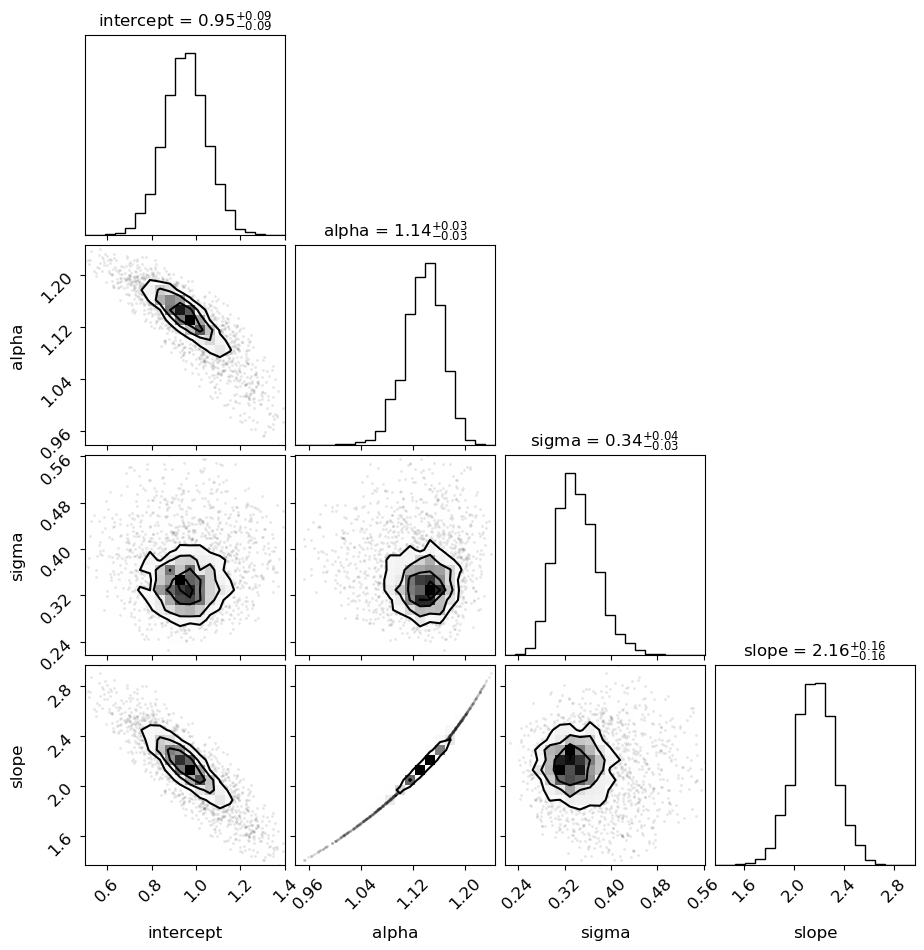

In [18]:
cornerplot(results) 

To verify how the nested sample evolved from one iteration to the next, you can inspect the trace plot:

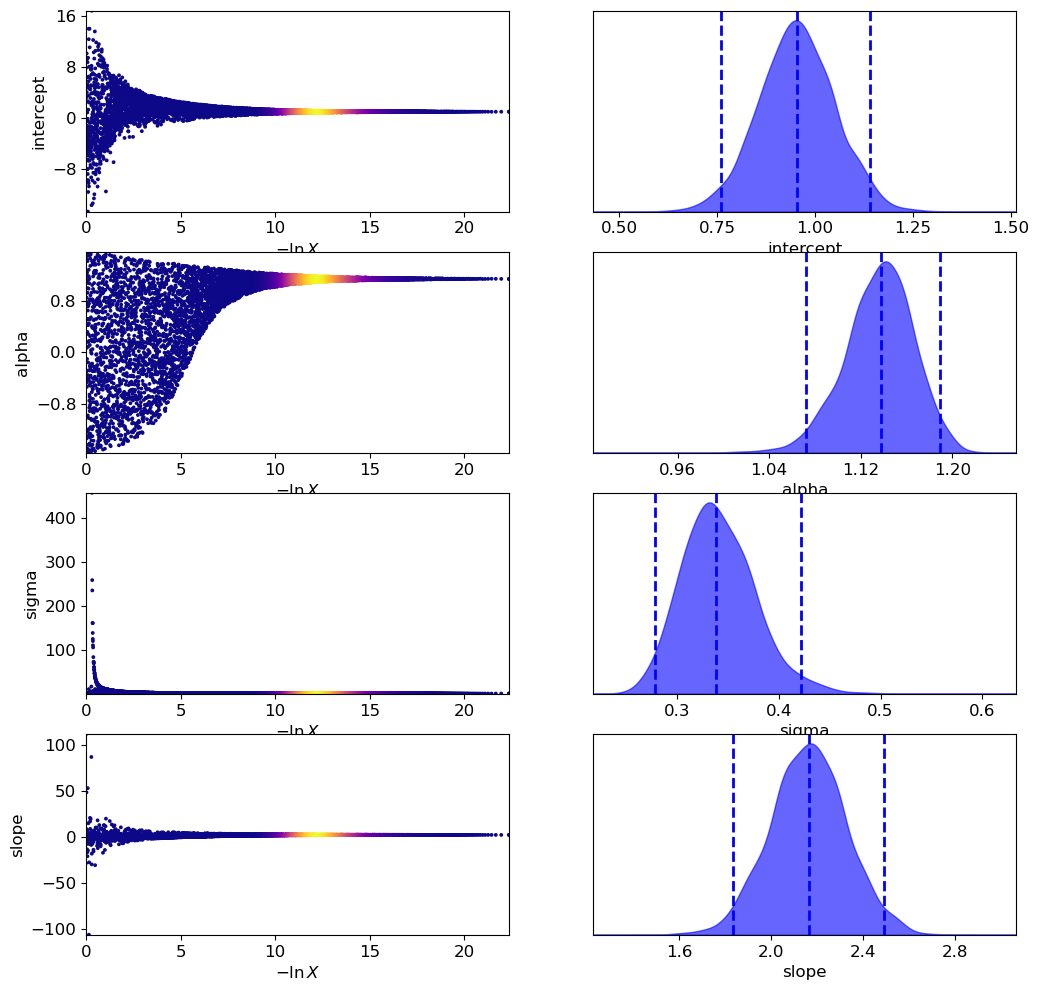

In [19]:
sampler.plot_trace() 

The mean posterior values of the fit parameters can be obtained as follows:

In [20]:
meanIntercept = results_df['intercept'].mean()
meanSlope = results_df['slope'].mean()

#### Plotting posterior sample on top of the data

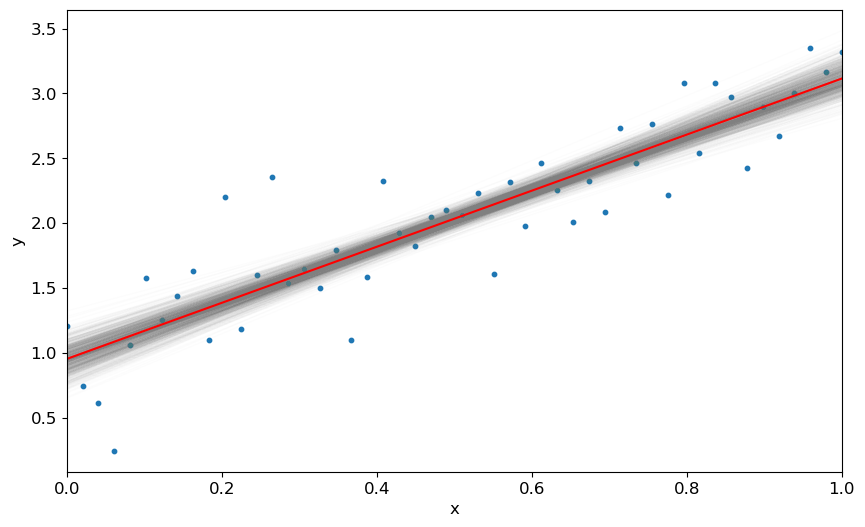

In [21]:
fig, ax = plt.subplots(1,1, figsize=(10,6)) 
ax.scatter(xobs, yobs, s=10)                                                               # plot our dataset

Nnew = 30
xnew = np.linspace(0, 1, Nnew)                       

N = len(results['samples'])                                                         # Nr of points in our posterior sample
M = N//1000                                                              # The number of posterior samples we will plot
for n in range(0, N, M):
    intercept, alpha, sigma, slope = results['samples'][n]
    ax.plot(xnew, intercept + slope * xnew, c="gray", linewidth=1, alpha=0.02)

ax.plot(xnew, meanIntercept + meanSlope * xnew, c="red", linewidth=1.5)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim(0,1)
plt.show()

#### Posterior predictive distribution

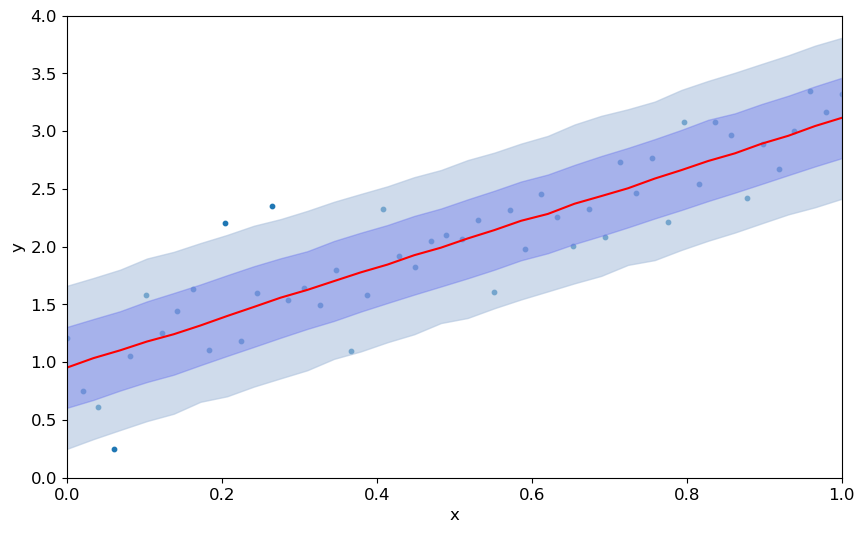

In [22]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.scatter(xobs, yobs, s=10)                                             # Our original dataset

band = PredictionBand(xnew)
for intercept, alpha, sigma, slope in sampler.results['samples']:
    mu = intercept + slope * xnew
    ynew = sp.stats.norm.rvs(mu, sigma)                                  # not just `mu` because this would correspond with a CI rather than a PI.
    band.add(ynew)

band.line(color='r')                                              # The mean of the posterior 
band.shade(color='blue', alpha=0.4)                               # The 1-sigma quantile
band.shade(q=0.475, color='lightsteelblue', alpha=0.6)            # Shade the region between 0.5-q and 0.5+q quantiles

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim(0,1)
ax.set_ylim(0,4)
plt.show()

How does this compare with a 95% prediction interval obtained using least-squares?

In [23]:
df = pd.DataFrame({'y' : yobs, 'x': xobs})
N = len(yobs)
K = 2
olsFit = sm.OLS.from_formula(formula='y ~ x', data=df).fit()
s2 = np.sum(olsFit.resid**2) / (N-K)                               # Estimated variance of the (homescedastic) noise
covMatrix = olsFit.cov_params()                                    # Covariance matrix of the fit parameters
designX = sm.add_constant(np.column_stack([xnew]))                 # Design matrix
ynew = designX @ olsFit.params                                     # Estimated y-values given the xnew values.

sigmaPI_y = np.zeros_like(xnew)
sigmaCI_y = np.zeros_like(xnew)
for n in range(len(xnew)):
    xvec = [1, xnew[n]]
    sigmaPI_y[n] = np.sqrt(xvec @ covMatrix @ xvec + s2)           # Uncertainty on the predicted y-value
    sigmaCI_y[n] = np.sqrt(xvec @ covMatrix @ xvec)
   
Tdistrib = sp.stats.t(N-K)                                         # Student's T-distribution
tMultiplier = Tdistrib.ppf(1-0.05/2)                               # 95% prediction interval

lowerPI = ynew - tMultiplier * sigmaPI_y                           # PI stands for Prediction Interval
upperPI = ynew + tMultiplier * sigmaPI_y
lowerCI = ynew - tMultiplier * sigmaCI_y                           # CI stands for Confidence Interval
upperCI = ynew + tMultiplier * sigmaCI_y

Plot the frequentist prediction interval on top of the Bayesian quantile interval: 

(0.0, 4.0)

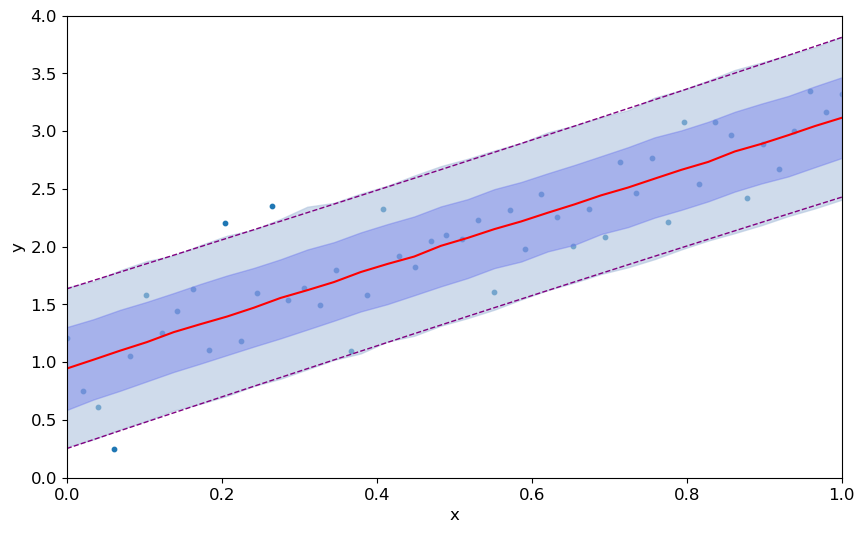

In [24]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.scatter(xobs, yobs, s=10)                                             # Our original dataset

band = PredictionBand(xnew)
for intercept, alpha, sigma, slope in sampler.results['samples']:
    mu = intercept + slope * xnew
    ynew = sp.stats.norm.rvs(mu, sigma)                                  # not just `mu` because this would correspond with a CI rather than a PI.
    band.add(ynew)

band.line(color='r')                                                     # The median of the posterior 
band.shade(color='blue', alpha=0.4)                                      # The 1-sigma quantile of the posterior predictive distribution
band.shade(q=0.475, color='lightsteelblue', alpha=0.6)                   # Shade the region between 0.5-q and 0.5+q quantiles

ax.plot(xnew, lowerPI, c="purple", linewidth=1, linestyle='--')          # The Frequentist versoin
ax.plot(xnew, upperPI, c="purple", linewidth=1, linestyle='--')

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim(0,1)
ax.set_ylim(0,4)

Back to [contents](#Contents).

---

## Robust regression using a StudentT likelihood with UltraNest

Create a synthetic dataset with outliers:

In [25]:
rng = np.random.default_rng(82)
N = 30
xobs = np.linspace(0, 20, N)
theta0 = 5
theta1 = 1
theta2 = 0.0001
mu = theta0 + theta1 * xobs + theta2 * (xobs-5)**2        # noiseless
sigma = 1.0                                               # Stdev of the noise
yobs = mu + rng.normal(0, sigma, N)                       # with noise
yobs[[0, 2, 7]] += 9                                      # 3 outliers
yobs[[19,21,23,25,28]] -= 9                               # 5 more outliers

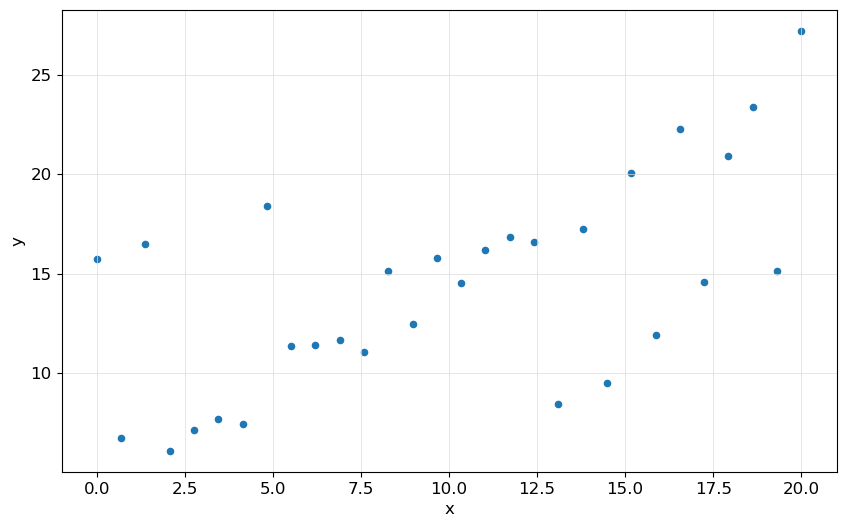

In [26]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.scatter(xobs, yobs, s=20)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

#### The non-robust Bayesian model

$\mu = \theta_0+\theta_1 x$

$\theta_1 = \tan(\alpha)$

$\alpha \sim {\rm Uniform}(-\pi/2, +\pi/2)$ 

$\theta_0 \sim {\rm Normal}(0, 10)$

$\sigma \sim {\rm HalfCauchy}(\beta=3)$

$y \sim {\rm Normal}(\mu, \sigma)$

In [27]:
def my_prior_transform(cube):
    params = np.empty(4)
    params[0] = sp.stats.norm.ppf(cube[0], 0, 10)                              # intercept
    params[1] = sp.stats.uniform.ppf(cube[1], -np.pi/2, np.pi)                 # alpha: loc,scale -> [loc, loc+scale] = [-pi/2, +pi/2]
    params[2] = sp.stats.halfcauchy.ppf(cube[2], 0.0, 3.0)                     # sigma
    params[3] = np.tan(params[1])                                              # slope
    return params


def my_loglikelihood(params):
    intercept, alpha, sigma, slope = params
    mu = intercept + slope * xobs
    loglike = sp.stats.norm.logpdf(yobs, mu, sigma).sum()
    return loglike

In [28]:
param_names = ["intercept", "alpha", "sigma"]
derived_param_names = ["slope"]
sampler = ultranest.ReactiveNestedSampler(param_names, my_loglikelihood, my_prior_transform, derived_param_names)
results = sampler.run()
sampler.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-8e+01   [-84.7175..-84.7173]*| it/evals=4950/9588 eff=53.8746% N=400     
[ultranest] Likelihood function evaluations: 9595
[ultranest]   logZ = -92.5 +- 0.1106
[ultranest] Effective samples strategy satisfied (ESS = 1926.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.13 bs:0.11 tail:0.01 total:0.11 required:<0.50
[ultranest] done iterating.

logZ = -92.481 +- 0.266
  single instance: logZ = -92.481 +- 0.125
  bootstrapped   : logZ = -92.504 +- 0.266
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    intercept           : 1.9   │ ▁ ▁▁▁▁▁▁▁▂▂▃▃▄▆▇▇▇▇▇▇▅▃▃▂▁▁▁▁▁▁ ▁   ▁ │16.6      8.9 +- 1.5
    alpha               : -0.04 │ ▁   ▁▁▁▁▁▁▁▁▁▁▂▂▃▃▅▅▇▇▇▇▆▅▅▃▃▃▁▁▁▁▁▁▁ │0.84      0.49 +- 0.10
    sigma               : 2.22  │ ▁  ▁▁▁▂

Note the way too high value of $\sigma$.

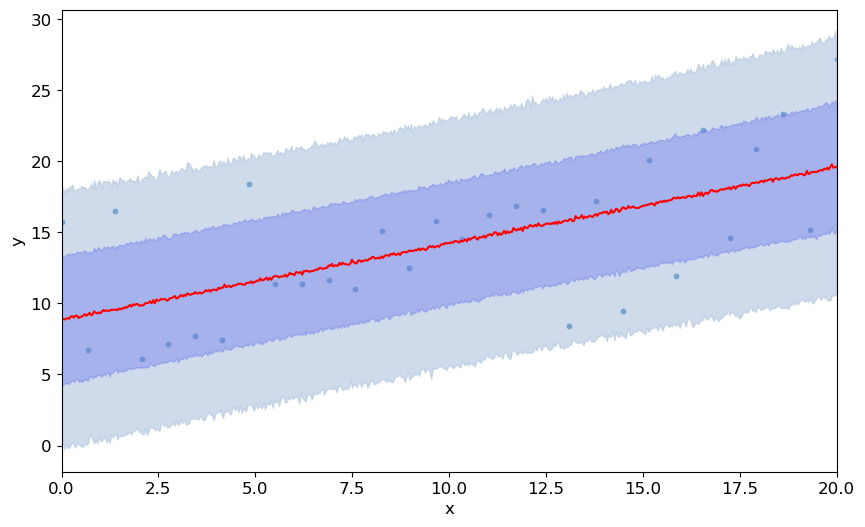

In [29]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.scatter(xobs,yobs, s=10)                                             # Our original dataset

Nnew = 500
xnew = np.linspace(0, 20, Nnew) 

band = PredictionBand(xnew)
for intercept, alpha, sigma, slope in sampler.results['samples']:
    ynew = sp.stats.norm.rvs(intercept + slope * xnew, sigma) 
    band.add(ynew)

band.line(color='r')                                              # The mean of the posterior 
band.shade(color='blue', alpha=0.4)                               # The 1-sigma quantile
band.shade(q=0.475, color='lightsteelblue', alpha=0.6)            # Shade the region between 0.5-q and 0.5+q quantiles

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim(0,20)
plt.show()

#### A more robust Bayesian model

We use the Student's T-distribution instead of a Gaussian distribution for the likelihood:

$\mu = \theta_0+\theta_1 x$

$\theta_1 = \tan(\alpha)$

$\alpha \sim {\rm Uniform}(-\pi/2, +\pi/2)$ 

$\theta_0 \sim {\rm Normal}(0, 10)$

$\sigma \sim {\rm HalfCauchy}(\beta=3)$

$y \sim {\rm T}(\mu, \sigma, \nu=1)$

Note that the T-distribution with $\nu=1$ is the Cauchy distribution which has very broad tails.

In [30]:
def my_prior_transform(cube):
    params = np.empty(4)
    params[0] = sp.stats.norm.ppf(cube[0], 0, 10)                              # intercept
    params[1] = sp.stats.uniform.ppf(cube[1], -np.pi/2, np.pi)                 # alpha: loc,scale -> [loc, loc+scale] = [-pi/2, +pi/2]
    params[2] = sp.stats.halfcauchy.ppf(cube[2], 0.0, 3.0)                     # sigma
    params[3] = np.tan(params[1])                                              # slope
    return params


def my_loglikelihood(params):
    intercept, alpha, sigma, slope = params
    mu = intercept + slope * xobs
    loglike = sp.stats.t.logpdf(yobs, 1, mu, sigma).sum()                      # nu=1
    return loglike

In [31]:
param_names = ["intercept", "alpha", "sigma"]
derived_param_names = ["slope"]
sampler = ultranest.ReactiveNestedSampler(param_names, my_loglikelihood, my_prior_transform, derived_param_names)
results = sampler.run()
sampler.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-8e+01   [-83.9427..-83.9425]*| it/evals=5240/9922 eff=55.0305% N=400    
[ultranest] Likelihood function evaluations: 9951
[ultranest]   logZ = -92.42 +- 0.08479
[ultranest] Effective samples strategy satisfied (ESS = 1942.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.13 bs:0.08 tail:0.01 total:0.09 required:<0.50
[ultranest] done iterating.

logZ = -92.464 +- 0.207
  single instance: logZ = -92.464 +- 0.132
  bootstrapped   : logZ = -92.420 +- 0.207
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    intercept           : 1.31  │ ▁   ▁▁▁▁▁▁▂▃▄▅▇▇▇▆▅▅▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁ │9.72      5.09 +- 0.82
    alpha               : 0.311 │ ▁     ▁  ▁▁ ▁▁▁▁▁▁▁▁▁▁▁▂▃▅▆▇▇▇▅▃▂▁▁▁▁ │0.918     0.757 +- 0.044
    sigma               : 0.43  │ ▁▁

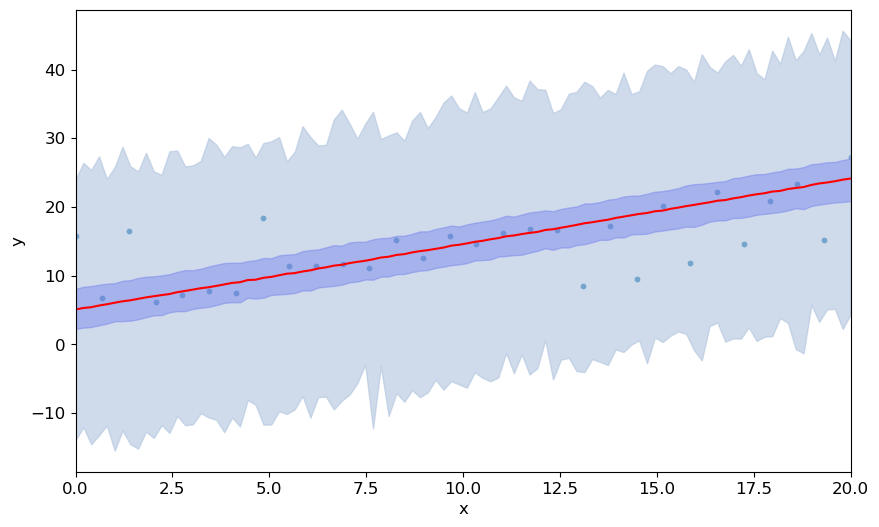

In [32]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.scatter(xobs,yobs, s=10)                                             # Our original dataset

Nnew = 100
xnew = np.linspace(0, 20, Nnew) 

band = PredictionBand(xnew)
for intercept, alpha, sigma, slope in sampler.results['samples']:
    mu = intercept + slope * xnew
    ynew = sp.stats.t.rvs(1, mu, sigma)
    band.add(ynew)

band.line(color='r')                                              # The mean of the posterior 
band.shade(color='blue', alpha=0.4)                               # The 1-sigma quantile
band.shade(q=0.475, color='lightsteelblue', alpha=0.6)            # Shade the region between 0.5-q and 0.5+q quantiles

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim(0,20)
plt.show()

The non-smooth appearance of the prediction band is due to the rather primitive way UltraNest computes it.

One can try different values for the parameter $\nu$ of the T-distribution and do a sensitivity analysis. Alternatively, one can include a hyperprior distribution for $\nu$. Gelman et al. (2003) suggests that one might try

$$ \nu^{-1} \sim {\rm Uniform}(0,1) $$

This hyperprior distribution favors long-tailed likelihoods, with half of the prior probability falling between $T(\nu=1)$ and $T(\nu=2)$.

Back to [contents](#Contents).

---

## Robust regression using the Hogg approach with UltraNest

We use the same outlier dataset as in the previous example:

In [33]:
rng = np.random.default_rng(82)
N = 30
xobs = np.linspace(0, 20, N)
theta0 = 5
theta1 = 1
theta2 = 0.0001
mu = theta0 + theta1 * xobs + theta2 * (xobs-5)**2     # noiseless
sigma = 1.0                                            # Stdev of the noise
yobs = mu + rng.normal(0, sigma, N)                    # with noise
yobs[[0, 2, 7]] += 9                                   # 3 outliers
yobs[[19,21,23,25,28]] -= 9                            # 5 more outliers

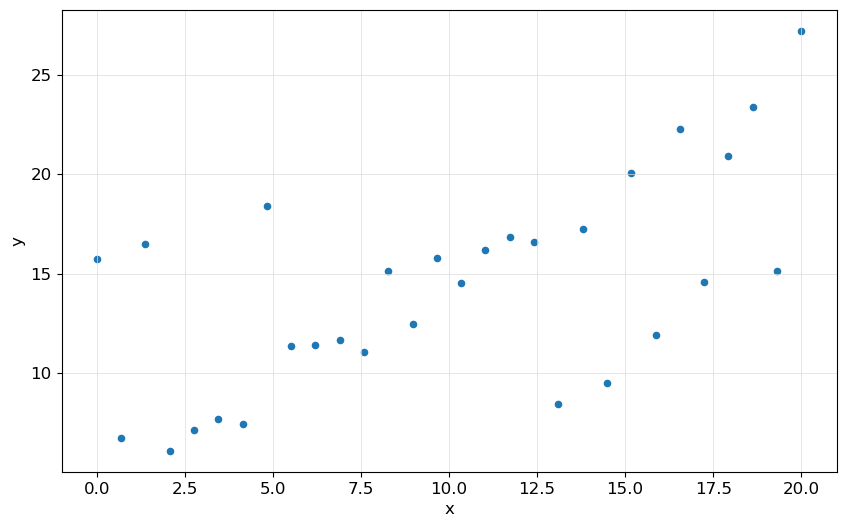

In [34]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.scatter(xobs, yobs, s=20)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

The following code was inspired by the article of [Hogg et al. (2010)](https://arxiv.org/pdf/1008.4686v1.pdf). In particular, see their equation (17). This involves implementing a custom likelihood function using the `pm.DensityDist` feature.

In [35]:
def my_prior_transform(cube):
    params = np.empty(8)
    params[0] = sp.stats.halfcauchy.ppf(cube[0], 0.0, 3.0)                     # sigmaInlier
    params[1] = sp.stats.norm.ppf(cube[1], 0, 10)                              # intercept
    params[2] = sp.stats.uniform.ppf(cube[2], -np.pi/2, np.pi)                 # alpha
    params[3] = sp.stats.uniform.ppf(cube[3], -50, 100)                        # muOutlier
    params[4] = sp.stats.uniform.ppf(cube[4], -2, 4)                           # logSigmaOutlier
    params[5] = sp.stats.uniform.ppf(cube[5], 0.01, 1.0-0.01)                  # probOutlier
    params[6] = np.tan(params[2])                                              # slope
    params[7] =  np.sqrt(np.exp(params[4])**2 + params[0]**2)                  # sigmaOutlier
    return params


def my_loglikelihood(params):
    sigmaInlier, intercept, alpha, muOutlier, logSigmaOutlier, probOutlier, slope, sigmaOutlier = params
    muInlier     = intercept + slope * xobs
    likeInlier   = 1./(sigmaInlier  * np.sqrt(2*np.pi)) * np.exp(-0.5 * (yobs - muInlier)**2 / sigmaInlier**2)
    likeOutlier  = 1./(sigmaOutlier * np.sqrt(2*np.pi)) * np.exp(-0.5 * (yobs - muOutlier)**2 / sigmaOutlier**2)
    logLike      = np.log((1 - probOutlier) * likeInlier + probOutlier * likeOutlier).sum()
    return logLike

In [36]:
param_names = ["sigmaInlier", "intercept", "alpha", "muOutlier", "logSigmaOutlier", "probOutlier"]
derived_param_names = ["slope", "logSigmaOutlier"]
sampler = ultranest.ReactiveNestedSampler(param_names, my_loglikelihood, my_prior_transform, derived_param_names)
results = sampler.run()
sampler.print_results()

[ultranest] Sampling 400 live points from prior ...
[ultranest] Widening roots to 426 live points (have 400 already) ...
[ultranest] Sampling 26 live points from prior ...
[ultranest] Widening roots to 455 live points (have 426 already) ...
[ultranest] Sampling 29 live points from prior ...


<ipython-input-35-fa873d485542>:19: RuntimeWarning: divide by zero encountered in log
  logLike      = np.log((1 - probOutlier) * likeInlier + probOutlier * likeOutlier).sum()


<ipython-input-35-fa873d485542>:19: RuntimeWarning: divide by zero encountered in log
  logLike      = np.log((1 - probOutlier) * likeInlier + probOutlier * likeOutlier).sum()
<ipython-input-35-fa873d485542>:19: RuntimeWarning: divide by zero encountered in log
  logLike      = np.log((1 - probOutlier) * likeInlier + probOutlier * likeOutlier).sum()
<ipython-input-35-fa873d485542>:19: RuntimeWarning: divide by zero encountered in log
  logLike      = np.log((1 - probOutlier) * likeInlier + probOutlier * likeOutlier).sum()


<ipython-input-35-fa873d485542>:19: RuntimeWarning: divide by zero encountered in log
  logLike      = np.log((1 - probOutlier) * likeInlier + probOutlier * likeOutlier).sum()


<ipython-input-35-fa873d485542>:19: RuntimeWarning: divide by zero encountered in log
  logLike      = np.log((1 - probOutlier) * likeInlier + probOutlier * likeOutlier).sum()
<ipython-input-35-fa873d485542>:19: RuntimeWarning: divide by zero encountered in log
  logLike      = np.log((1 - probOutlier) * likeInlier + probOutlier * likeOutlier).sum()


<ipython-input-35-fa873d485542>:19: RuntimeWarning: divide by zero encountered in log
  logLike      = np.log((1 - probOutlier) * likeInlier + probOutlier * likeOutlier).sum()


<ipython-input-35-fa873d485542>:19: RuntimeWarning: divide by zero encountered in log
  logLike      = np.log((1 - probOutlier) * likeInlier + probOutlier * likeOutlier).sum()


<ipython-input-35-fa873d485542>:19: RuntimeWarning: divide by zero encountered in log
  logLike      = np.log((1 - probOutlier) * likeInlier + probOutlier * likeOutlier).sum()


<ipython-input-35-fa873d485542>:19: RuntimeWarning: divide by zero encountered in log
  logLike      = np.log((1 - probOutlier) * likeInlier + probOutlier * likeOutlier).sum()


<ipython-input-35-fa873d485542>:19: RuntimeWarning: divide by zero encountered in log
  logLike      = np.log((1 - probOutlier) * likeInlier + probOutlier * likeOutlier).sum()


<ipython-input-35-fa873d485542>:19: RuntimeWarning: divide by zero encountered in log
  logLike      = np.log((1 - probOutlier) * likeInlier + probOutlier * likeOutlier).sum()


<ipython-input-35-fa873d485542>:19: RuntimeWarning: divide by zero encountered in log
  logLike      = np.log((1 - probOutlier) * likeInlier + probOutlier * likeOutlier).sum()


<ipython-input-35-fa873d485542>:19: RuntimeWarning: divide by zero encountered in log
  logLike      = np.log((1 - probOutlier) * likeInlier + probOutlier * likeOutlier).sum()


<ipython-input-35-fa873d485542>:19: RuntimeWarning: divide by zero encountered in log
  logLike      = np.log((1 - probOutlier) * likeInlier + probOutlier * likeOutlier).sum()


<ipython-input-35-fa873d485542>:19: RuntimeWarning: divide by zero encountered in log
  logLike      = np.log((1 - probOutlier) * likeInlier + probOutlier * likeOutlier).sum()


<ipython-input-35-fa873d485542>:19: RuntimeWarning: divide by zero encountered in log
  logLike      = np.log((1 - probOutlier) * likeInlier + probOutlier * likeOutlier).sum()


<ipython-input-35-fa873d485542>:19: RuntimeWarning: divide by zero encountered in log
  logLike      = np.log((1 - probOutlier) * likeInlier + probOutlier * likeOutlier).sum()


<ipython-input-35-fa873d485542>:19: RuntimeWarning: divide by zero encountered in log
  logLike      = np.log((1 - probOutlier) * likeInlier + probOutlier * likeOutlier).sum()


<ipython-input-35-fa873d485542>:19: RuntimeWarning: divide by zero encountered in log
  logLike      = np.log((1 - probOutlier) * likeInlier + probOutlier * likeOutlier).sum()


[ultranest] Explored until L=-7e+01   [-70.0393..-70.0390]*| it/evals=8280/154666 eff=5.3336% N=400 
[ultranest] Likelihood function evaluations: 154742
[ultranest]   logZ = -86.03 +- 0.1154
[ultranest] Effective samples strategy satisfied (ESS = 2745.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.12 tail:0.01 total:0.12 required:<0.50
[ultranest] done iterating.

logZ = -86.068 +- 0.312
  single instance: logZ = -86.068 +- 0.181
  bootstrapped   : logZ = -86.027 +- 0.312
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    sigmaInlier         : 0.30  │ ▁▁▁▂▃▆▇▆▅▃▂▂▁▁▁▁▁▁▁▁▁▁ ▁▁▁▁         ▁ │4.64      1.24 +- 0.27
    intercept           : 1.03  │ ▁ ▁▁▁▁▁▁▂▄▅▇▇▇▆▃▂▁▁▁▁▁▁ ▁ ▁         ▁ │10.83     4.44 +- 0.62
    alpha               : 0.464 │ ▁    

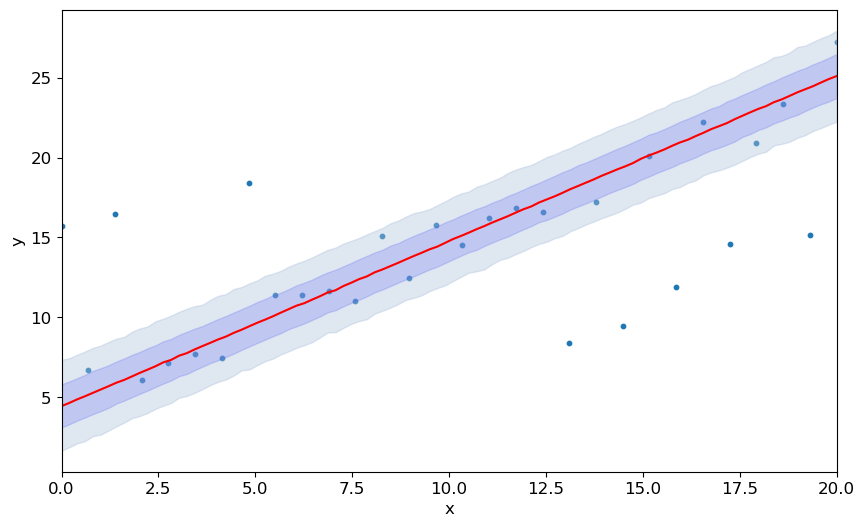

In [37]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.scatter(xobs,yobs, s=10)                                             # Our original dataset

Nnew = 100
xnew = np.linspace(0, 20, Nnew) 

band = PredictionBand(xnew)
for sigmaInlier, intercept, alpha, muOutlier, logSigmaOutlier, probOutlier, slope, sigmaOutlier in sampler.results['samples']:
    muInlier = intercept + slope * xnew
    ynew = sp.stats.norm.rvs(muInlier, sigmaInlier)  
    band.add(ynew)

band.line(color='r')                                              # The mean of the posterior 
band.shade(color='blue', alpha=0.2)                               # The 1-sigma quantile
band.shade(q=0.475, color='lightsteelblue', alpha=0.4)            # Shade the region between 0.5-q and 0.5+q quantiles

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim(0,20)
plt.show()

Back to [contents](#Contents).

---

## Piecewise linear regression with UltraNest

Create an artificial dataset

In [38]:
rng = np.random.default_rng(149)

N = 50
intercept1 = 1
slope1 = 2
intercept2 = 3.275
slope2 = -1.5

sigma = 0.15

xobs = np.linspace(0, 2, N)

piece1 = xobs < 0.65
piece2 = xobs >= 0.65
yobs = np.zeros(N)
yobs[piece1] = intercept1 + slope1 * xobs[piece1] 
yobs[piece2] = intercept2 + slope2 * xobs[piece2] 
yobs += rng.normal(0.0, sigma, N)

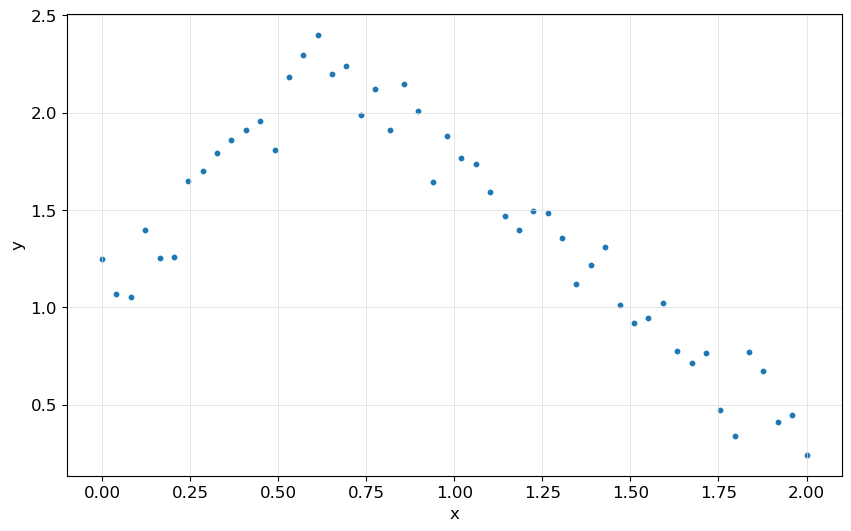

In [39]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.scatter(xobs, yobs, s=10)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

The goal is not only to derive the intercepts and the slopes of the linear pieces, but also the location of the switch point.

Our Bayesian model:

$\mu = \theta_0+\theta_1 x$   if $x <= x_0$

$\mu = \theta_2+\theta_3 x$   if $x > x_0$

$\theta_1 = \tan(\alpha_1)$

$\theta_3 = \tan(\alpha_2)$

$\alpha_1 \sim {\rm Uniform}(0, \pi/2)$ 

$\alpha_2 \sim {\rm Uniform}(-\pi/2, 0)$ 

$\theta_0 \sim {\rm Normal}(0, 5)$

$\theta_2 \sim {\rm Normal}(0, 5)$

$\sigma \sim {\rm HalfCauchy}(\beta=2)$

$y \sim {\rm Normal}(\mu, \sigma)$

In [40]:
def my_prior_transform(cube):
    params = np.empty(7)
    params[0] = sp.stats.norm.ppf(cube[0], 0, 5)                               # intercept1
    params[1] = sp.stats.uniform.ppf(cube[1], 0, np.pi/2)                      # alpha1
    params[2] = sp.stats.uniform.ppf(cube[2], -np.pi/2, np.pi/2)               # alpha2
    params[3] = sp.stats.norm.ppf(cube[3], 0.6, 0.25)                          # switchpoint
    params[4] = sp.stats.halfcauchy.ppf(cube[4], 0.0, 2.0)                     # sigma
    params[5] = np.tan(params[1])                                              # slope1
    params[6] = np.tan(params[2])                                              # slope2
    return params


def my_loglikelihood(params):
    intercept1, alpha1, alpha2, switchpoint, sigma, slope1, slope2 = params
    piece1 = xobs < switchpoint
    piece2 = xobs >= switchpoint
    mu = np.zeros_like(yobs)
    mu[piece1] = intercept1 + slope1 * xobs[piece1] 
    mu[piece2] = intercept1 + slope1 * switchpoint + slope2 * (xobs[piece2] - switchpoint)
    logLike = sp.stats.norm.logpdf(yobs, mu, sigma).sum()
    return logLike

In [41]:
param_names = ["intercept1", "alpha1", "alpha2", "switchpoint", "sigma"]
derived_param_names = ["slope1", "slope2"]
sampler = ultranest.ReactiveNestedSampler(param_names, my_loglikelihood, my_prior_transform, derived_param_names)
results = sampler.run()
sampler.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=4e+01  35.1457..35.1459]*| it/evals=9720/54087 eff=18.1049% N=400     
[ultranest] Likelihood function evaluations: 54172
[ultranest]   logZ = 15.52 +- 0.1647
[ultranest] Effective samples strategy satisfied (ESS = 2506.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.16 tail:0.01 total:0.16 required:<0.50
[ultranest] done iterating.

logZ = 15.461 +- 0.318
  single instance: logZ = 15.461 +- 0.207
  bootstrapped   : logZ = 15.522 +- 0.318
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    intercept1          : 0.755 │ ▁▁ ▁▁▁▁▁▁▁▂▂▃▄▅▆▆▇▇▇▆▆▅▄▃▂▁▁▁▁▁▁▁▁▁▁▁ │1.342     1.046 +- 0.063
    alpha1              : 0.907 │ ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▅▅▆▇▇▇▇▅▃▃▂▁▁▁▁▁ ▁ │1.251     1.116 +- 0.034
    alpha2              : -1.036│ ▁▁▁▁▁▁▁

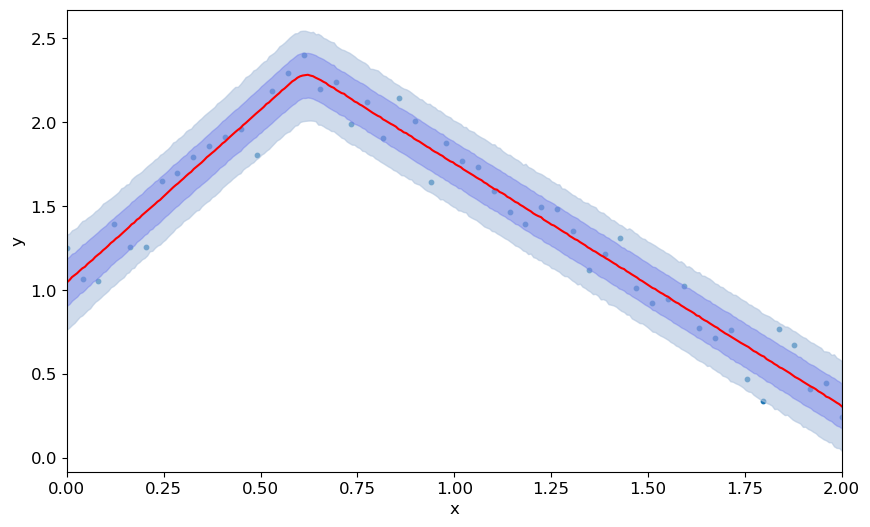

In [42]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.scatter(xobs,yobs, s=10)                                             # Our original dataset

Nnew = 300
xnew = np.linspace(0, 2, Nnew) 

band = PredictionBand(xnew)
for intercept1, alpha1, alpha2, switchpoint, sigma, slope1, slope2 in sampler.results['samples']:
    mu = np.zeros_like(xnew)
    piece1 = xnew < switchpoint
    piece2 = xnew >= switchpoint
    mu[piece1] = intercept1 + slope1 * xnew[piece1] 
    mu[piece2] = intercept1 + slope1 * switchpoint + slope2 * (xnew[piece2] - switchpoint)
    ynew = sp.stats.norm.rvs(mu, sigma) 
    band.add(ynew)

band.line(color='r')                                              # The mean of the posterior 
band.shade(color='blue', alpha=0.4)                               # The 1-sigma quantile
band.shade(q=0.475, color='lightsteelblue', alpha=0.6)            # Shade the region between 0.5-q and 0.5+q quantiles

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim(0,2)
plt.show()

Back to [contents](#Contents).

---

## Uncertainties in y and x with UltraNest

Load the dataset. 

In [11]:
url = "https://raw.githubusercontent.com/JorisDeRidder/DataAnalysisInPhysicsAndAstronomy/main/Datasets/M_sigma.csv"
data = pd.read_csv(url, comment='#')
data.head()

,xobs,xerr,yobs,yerr,Type
0,-0.279841,0.100,6.61,0.040,S
1,-0.425969,0.015,6.46,0.090,E
2,-0.096910,0.040,8.18,0.150,S
3,-0.289883,0.094,7.00,0.300,S
4,0.019116,0.050,8.23,0.205,E


In [12]:
print("Number of data points = {0}".format(len(data)))

Number of data points = 46


In [13]:
x = data['xobs'].values
xerr = data['xerr'].values
y = data['yobs'].values
yerr = data['yerr'].values

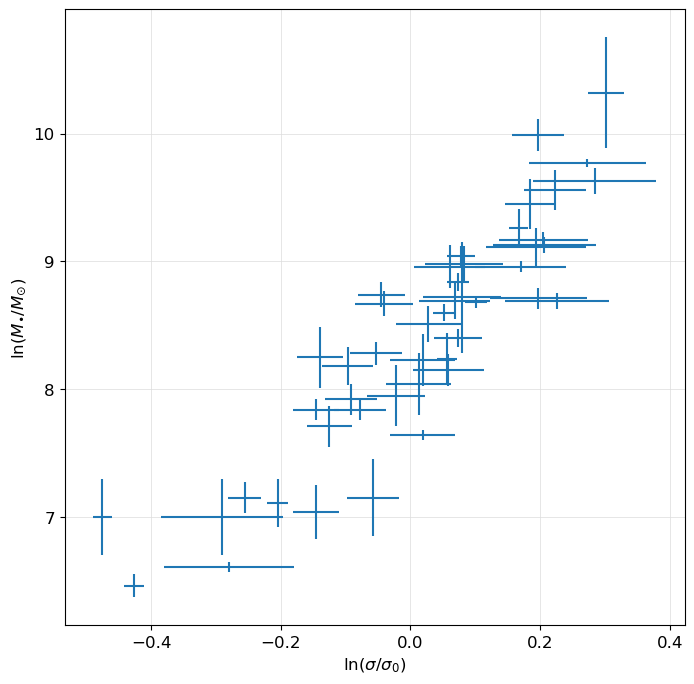

In [14]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.errorbar(x, y, xerr=xerr, yerr=yerr, linestyle='', ms=15)
ax.set_xlabel(r"$\ln(\sigma/\sigma_0)$")
ax.set_ylabel(r"$\ln(M_{\bullet}/M_{\odot})$")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

Replace each point of the original dataset with M=300 points sampled within the observed error bars:

In [15]:
rng = np.random.default_rng(789)
N = len(data)
M=300
xobs = np.zeros(N*M)
yobs = np.zeros(N*M)
for n in range(N):
    slice = np.s_[n*M:(n+1)*M]                                        # The slice corresponding to 1 galaxy
    xobs[slice] = rng.normal(x[n], xerr[n], size=M)
    yobs[slice] = rng.normal(y[n], yerr[n], size=M)

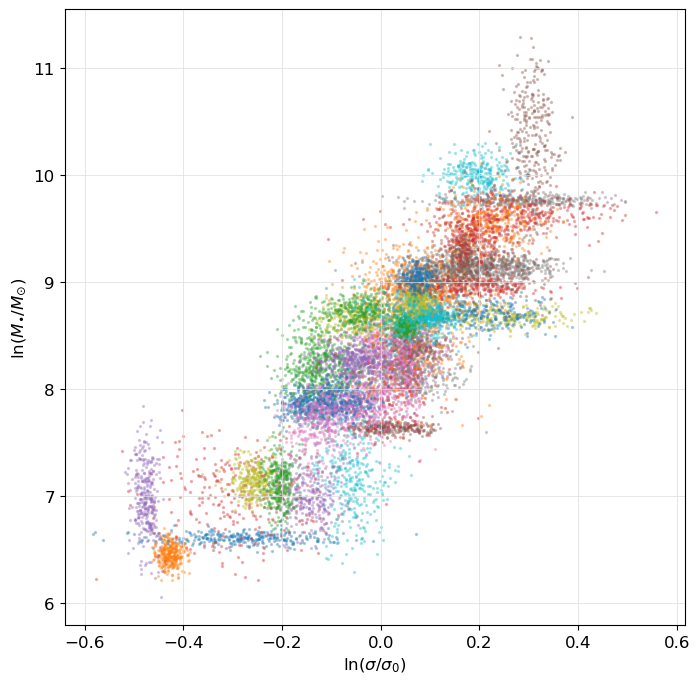

In [16]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
for n in range(N):
    slice = np.s_[n*M:(n+1)*M]                                        # The slice corresponding to 1 galaxy
    ax.scatter(xobs[slice], yobs[slice], s=2, alpha=0.3)
ax.set_xlabel(r"$\ln(\sigma/\sigma_0)$")
ax.set_ylabel(r"$\ln(M_{\bullet}/M_{\odot})$")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

Now we can proceed with the UltraNest model:

In [17]:
def my_prior_transform(cube):
    params = np.empty(4)
    params[0] = sp.stats.norm.ppf(cube[0], 0, 10)                              # intercept
    params[1] = sp.stats.uniform.ppf(cube[1], -np.pi/2, np.pi)                 # alpha
    params[2] = sp.stats.halfcauchy.ppf(cube[2], 0.0, 3.0)                     # zeta
    params[3] = np.tan(params[1])                                              # slope
    return params


def my_loglikelihood(params):
    intercept, alpha, zeta, slope = params
    mu = intercept + slope * xobs
    
    # For each galaxy, compute the weighted mean PDF
    
    pdf_samples = sp.stats.norm(mu, zeta).pdf(yobs)
    mean_pdfs = np.zeros(N)                            # N = number of galaxies
    for n in range(N):
        slice = np.s_[n*M:(n+1)*M]                     # The slice corresponding to 1 galaxy
        mean_pdfs[n] = pdf_samples[slice].mean()
        
    # Return the log of the mean PDFs
    
    loglike = np.log(mean_pdfs + 1.e-100).sum()        # Avoid log(0) so add a tiny number
    return loglike

In [18]:
param_names = ["intercept", "alpha", "zeta"]
derived_param_names = ["slope"]
sampler = ultranest.ReactiveNestedSampler(param_names, my_loglikelihood, my_prior_transform, derived_param_names)
results = sampler.run()
sampler.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Widening roots to 430 live points (have 400 already) ...
[ultranest] Sampling 30 live points from prior ...
[ultranest] Widening roots to 465 live points (have 430 already) ...
[ultranest] Sampling 35 live points from prior ...


[ultranest] Explored until L=-2e+01   [-21.2364..-21.2363]*| it/evals=7222/13432 eff=55.1940% N=400 0 0 
[ultranest] Likelihood function evaluations: 13472
[ultranest]   logZ = -34.7 +- 0.1082
[ultranest] Effective samples strategy satisfied (ESS = 1872.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.11 tail:0.01 total:0.11 required:<0.50
[ultranest] done iterating.

logZ = -34.710 +- 0.214
  single instance: logZ = -34.710 +- 0.173
  bootstrapped   : logZ = -34.695 +- 0.213
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    intercept           : 8.055 │ ▁ ▁ ▁▁▁▁▁▁▁▁▁▂▃▃▄▅▇▇▇▇▆▆▄▄▄▂▁▁▁▁▁▁▁▁▁ │8.569     8.342 +- 0.056
    alpha               : 1.222 │ ▁▁ ▁  ▁ ▁ ▁▁▁▁▁▁▁▂▂▃▄▅▆▇▇▇▇▆▄▂▂▁▁▁▁▁▁ │1.414     1.346 +- 0.017
    zeta                : 0.071 │

In [19]:
results_df = pd.DataFrame(data=results['samples'], columns=results['paramnames'])
results_df.describe(percentiles=[0.025, 0.5, 0.975])

,intercept,alpha,zeta,slope
count,7648.000000,7648.000000,7648.000000,7648.000000
mean,8.342276,1.345707,0.292670,4.392151
std,0.056008,0.016957,0.056312,0.336432
min,8.078749,1.230257,0.095379,2.822117
2.5%,8.233808,1.309799,0.188234,3.744055
50%,8.341422,1.346929,0.292547,4.392058
97.5%,8.452383,1.375882,0.410711,5.065315
max,8.545905,1.405043,0.585867,5.977694


In [20]:
meanIntercept = results_df['intercept'].mean()
meanSlope = results_df['slope'].mean()

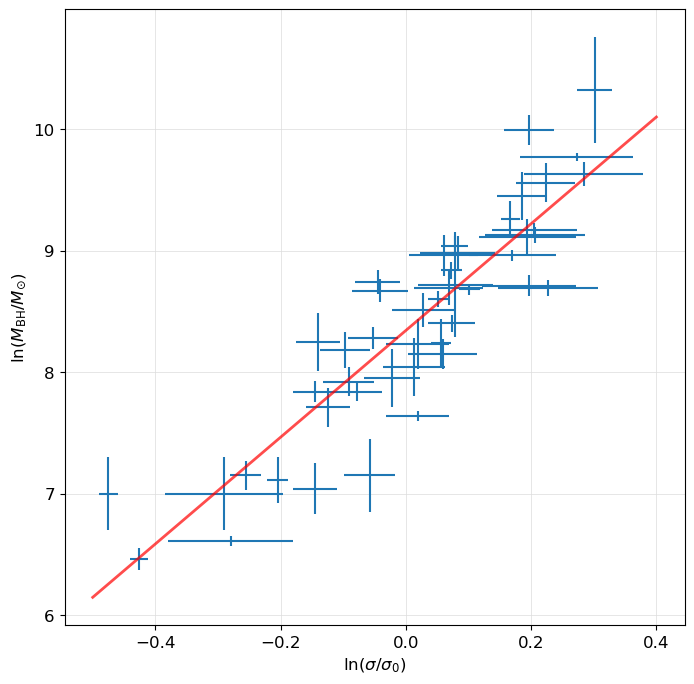

In [21]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

ax.errorbar(data['xobs'], data['yobs'], xerr=data['xerr'], yerr=data['yerr'], linestyle='', ms=15)

xvalues = np.linspace(-0.5, 0.4, 30)
yvalues = meanIntercept + meanSlope * xvalues
ax.plot(xvalues, yvalues, c="red", linewidth=2, alpha=0.7)

ax.set_xlabel(r"$\ln(\sigma/\sigma_0)$")
ax.set_ylabel(r"$\ln(M_{\rm BH}/M_{\odot})$")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

Back to [contents](#Contents).

---

## Modeling a distribution for a dataset with UltraNest

Load the dataset:

In [54]:
url = "https://raw.githubusercontent.com/JorisDeRidder/DataAnalysisInPhysicsAndAstronomy/main/Datasets/NGC6611.csv"
data = pd.read_csv(url, comment='#')
data.head()

,Mass
0,0.678
1,0.402
2,0.132
3,0.270
4,0.284


In [55]:
yobs = data['Mass'].values

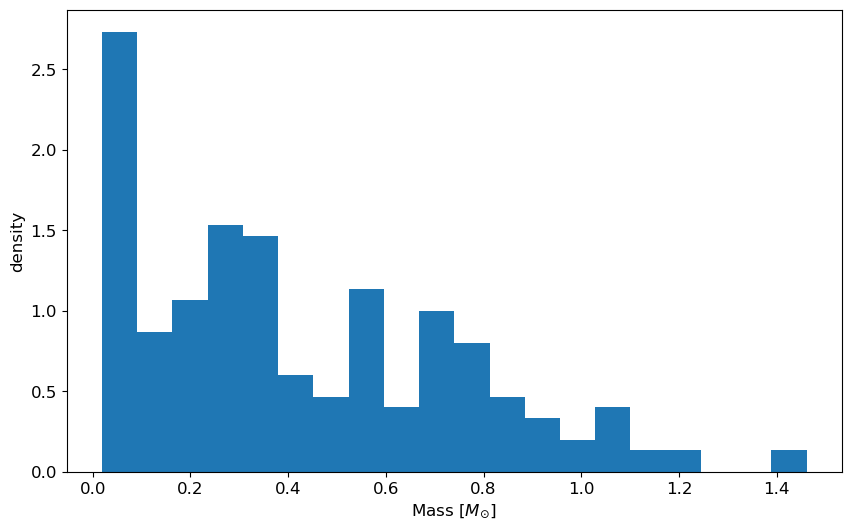

In [56]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.hist(data['Mass'].values, bins=20, density=True)
ax.set_xlabel(r"Mass $[M_{\odot}]$")
ax.set_ylabel("density")
plt.show()

We wish to fit a log-normal distribution:
    
$$f_X(x) = \frac{1}{x\sigma\sqrt{2\pi}} \ \exp\left(-\frac{(\ln x - \mu)^2}{2\sigma^2} \right)$$

$y \sim $ log-Normal $(\mu, \sigma^2)$

$\mu \sim {\rm Normal}(0, 10)$

$\sigma^2 \sim$ HalfNormal $(0, 50)$

In [57]:
def my_prior_transform(cube):
    params = cube.copy()
    params[0] = sp.stats.norm.ppf(cube[0], 0, 10)                              # mu
    params[1] = sp.stats.halfnorm.ppf(cube[1], 0.0, 50)                        # sigma
    return params


def my_loglikelihood(params):
    mu, sigma = params
    loglike = sp.stats.lognorm.logpdf(yobs, sigma, 0.0, np.exp(mu)).sum()      # Cf the peculiar definition of log-normal in scipy.stats.
    return loglike

In [58]:
param_names = ["mu", "sigma"]
sampler = ultranest.ReactiveNestedSampler(param_names, my_loglikelihood, my_prior_transform)
results = sampler.run()
sampler.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-4e+01   [-39.6184..-39.6183]*| it/evals=6360/8631 eff=77.2689% N=400     
[ultranest] Likelihood function evaluations: 8663
[ultranest]   logZ = -50.96 +- 0.1097
[ultranest] Effective samples strategy satisfied (ESS = 1611.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.11 tail:0.01 total:0.11 required:<0.50
[ultranest] done iterating.

logZ = -50.961 +- 0.260
  single instance: logZ = -50.961 +- 0.161
  bootstrapped   : logZ = -50.962 +- 0.259
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    mu                  : -1.541│ ▁▁▁▁▁▁▁▁▁▂▂▃▃▅▅▇▇▇▇▇▆▅▅▄▃▃▂▂▁▁▁▁▁▁▁▁▁ │-0.958    -1.254 +- 0.072
    sigma               : 0.846 │ ▁▁▁▁▁▁▁▂▃▄▄▆▅▆▇▇▇▇▅▆▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁ ▁ │1.286     1.034 +- 0.052



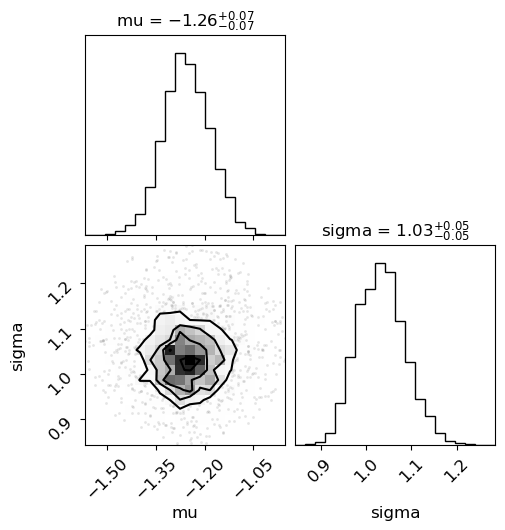

In [59]:
cornerplot(results) 

$\mu$ and $\sigma$ seem uncorrelated.

The following aims to overplot the mean log-normal distribution over the observed density. SciPy has a bit of a deviating version of the log-normal distribution, so we need our customary function:

In [60]:
def logNormal(x, mu, sigma):
    return np.exp(-(np.log(x) - mu)**2/2/sigma**2) / x / sigma / np.sqrt(2*np.pi)

In [61]:
muValues = results['samples'][:,0]
sigmaValues = results['samples'][:,1]
muMean = muValues.mean()
sigmaMean = sigmaValues.mean()
muLower = np.quantile(muValues, 0.025)
muUpper = np.quantile(muValues, 0.975)
sigmaLower = np.quantile(sigmaValues, 0.025)
sigmaUpper = np.quantile(sigmaValues, 0.975)

In [62]:
xvalues = np.linspace(0.01, 1.5, 100)
yvaluesMean  = logNormal(xvalues, muMean, sigmaMean)
yvaluesLower = logNormal(xvalues, muLower, sigmaLower)
yvaluesUpper = logNormal(xvalues, muUpper, sigmaUpper)

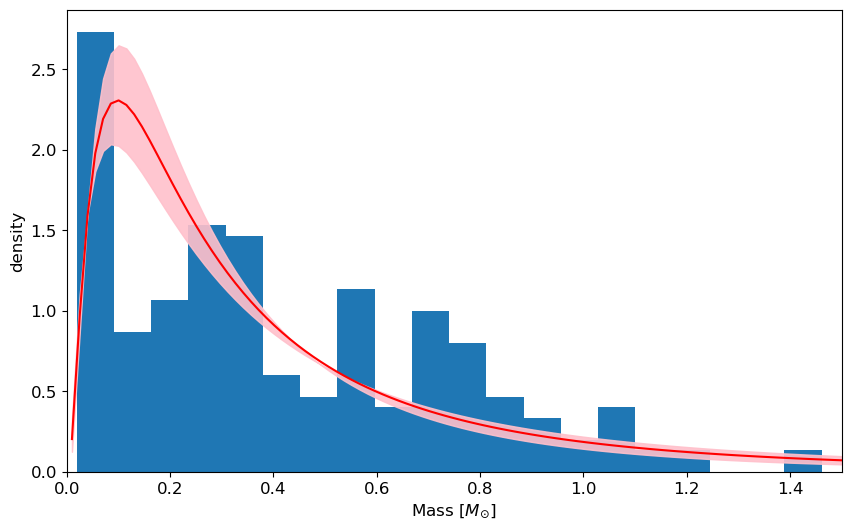

In [63]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.hist(data['Mass'].values, bins=20, density=True)

ax.fill_between(xvalues, yvaluesLower, yvaluesUpper, color="pink", alpha=0.9)
ax.plot(xvalues, yvaluesMean, c="red", linewidth=1.5)

ax.set_xlabel(r"Mass $[M_{\odot}]$")
ax.set_ylabel("density")
ax.set_xlim(0, 1.5)
plt.show()

Back to [contents](#Contents).

---

## Fitting a logit model with UltraNest

Load the dataset:

In [64]:
url = "https://raw.githubusercontent.com/JorisDeRidder/DataAnalysisInPhysicsAndAstronomy/main/Datasets/Red_spirals.csv"
data = pd.read_csv(url, comment='#')
data.head()

,redshift,g_r,g_r_err,fracdev,type
0,0.0833,0.695,0.020,0.42,1
1,0.0735,0.701,0.021,0.46,1
2,0.0642,0.756,0.039,0.00,1
3,0.0621,0.662,0.017,0.32,1
4,0.0661,0.687,0.018,0.40,1


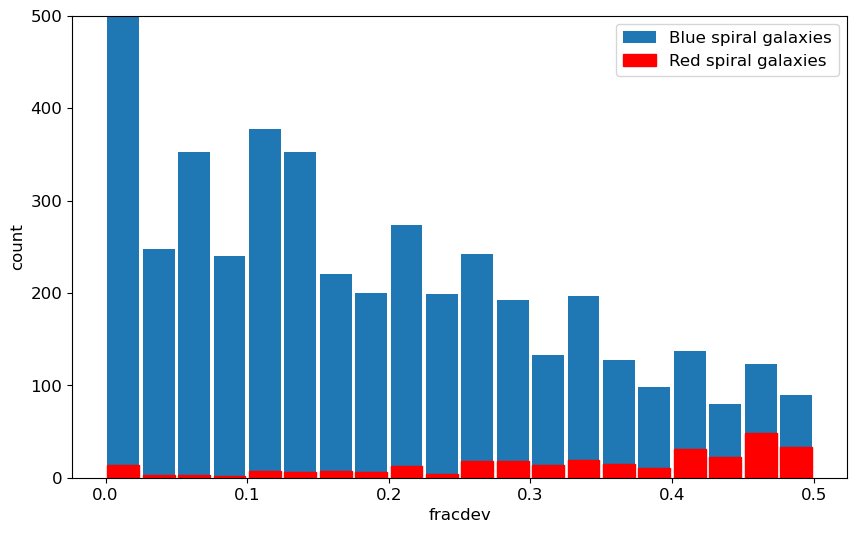

In [65]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

red = data['type'] == 1
blue = data['type'] == 0
ax.hist(data.loc[blue, 'fracdev'], bins=20, rwidth=0.9, label="Blue spiral galaxies")
ax.hist(data.loc[red, 'fracdev'], bins=20, facecolor="red", edgecolor="red", rwidth=0.9, label="Red spiral galaxies")

ax.legend(loc='upper right')
ax.set_xlabel("fracdev")
ax.set_ylabel("count")
ax.set_ylim(0, 500)
plt.show()

In [66]:
xobs = data['fracdev'].values                              # Float
yobs = data['type']                                        # Binary: 0 or 1 

In [67]:
def my_prior_transform(cube):
    params = cube.copy()
    params[0] = sp.stats.norm.ppf(cube[0], 0, 5)                              # theta_0
    params[1] = sp.stats.norm.ppf(cube[1], 0, 5)                              # theta_1
    return params


def my_loglikelihood(params):
    theta0, theta1 = params
    p = expit(theta0 + theta1 * xobs)                                          # expit(x) = 1/(1+exp(-x))
    loglike = sp.stats.bernoulli.logpmf(yobs, p).sum()                         # Discrete distributions have a pmf() rather than a pdf()
    return loglike

In [68]:
param_names = ["theta0", "theta1"]
sampler = ultranest.ReactiveNestedSampler(param_names, my_loglikelihood, my_prior_transform)
results = sampler.run()
sampler.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+03  .51 [-953.5188..-953.5187]*| it/evals=5220/7286 eff=75.8060% N=400     
[ultranest] Likelihood function evaluations: 7299
[ultranest]   logZ = -962 +- 0.09551
[ultranest] Effective samples strategy satisfied (ESS = 1612.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.14 bs:0.10 tail:0.01 total:0.10 required:<0.50
[ultranest] done iterating.

logZ = -961.980 +- 0.231
  single instance: logZ = -961.980 +- 0.137
  bootstrapped   : logZ = -961.965 +- 0.231
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    theta0              : -5.56 │ ▁▁▁▁▁▁▁▁▁▂▂▂▃▄▄▅▇▇▇▇▇▇▆▆▄▄▃▂▂▂▁▁▁▁▁ ▁ │-4.26     -4.88 +- 0.16
    theta1              : 6.05  │ ▁ ▁▁▁▁▁▁▁▁▂▂▄▄▄▅▇▇▇▆▆▆▅▃▃▃▂▁▁▁▁▁▁▁▁▁▁ │10.08     8.06 +- 0.48



In [69]:
theta0 = results['samples'][:,0]
theta1 = results['samples'][:,1]

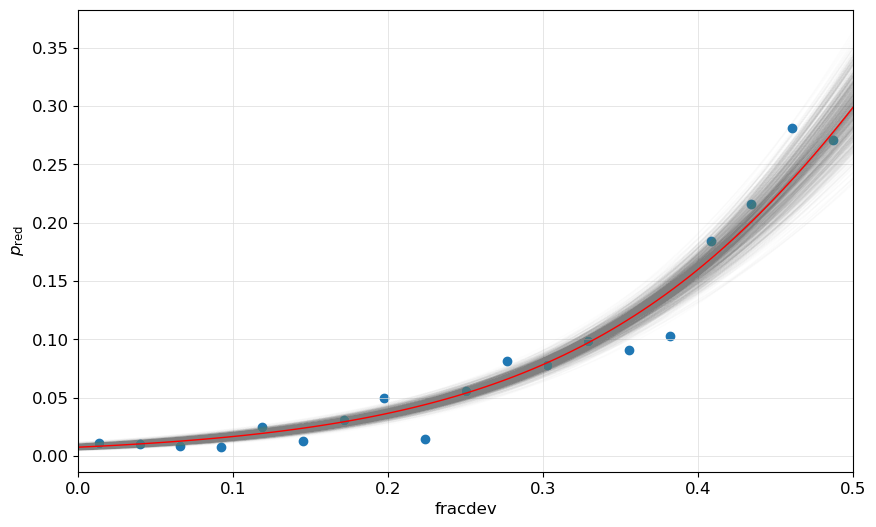

In [70]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

# The data points

bins = np.linspace(0, 0.5, 20)
binCenters = (bins[1:] + bins[:-1])/2.
allGalaxies, dummy = np.histogram(data['fracdev'], bins=bins)
redGalaxies, dummy = np.histogram(data.loc[red, 'fracdev'], bins=bins) 
fraction = redGalaxies / allGalaxies
ax.scatter(binCenters, fraction)

# A selection of posterior samples

xvalues = np.linspace(0, 0.5, 100)
M = len(theta0)//1000
for n in range(0, len(theta0), M):
    yvalues = expit(theta0[n]+theta1[n]*xvalues) 
    ax.plot(xvalues, yvalues, c="gray", linewidth=1, alpha=0.02)

# The mean fit

xvalues = np.linspace(0, 0.5, 100)
yvalues = expit(theta0.mean() + theta1.mean() * xvalues)
ax.plot(xvalues, yvalues, color="red", linewidth=1)

# Labels and grid

ax.set_xlabel("fracdev")
ax.set_ylabel(r"$p_{\rm red}$")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
ax.set_xlim(0,0.5)
plt.show()

Back to [contents](#Contents).

---

## A multinomial logistic model with UltraNest

We have 3 classes, and a parameter 'x' that we can measure for each object we study. The probability that an object belongs to a particular class depends on its measured x-values. We aim to put forward a model for this dependence, and get posterior distributions for the model parameters.

The reason why it's called a "multinomial" model is that we will model the data with a Multinomial probability distribution:

$$ y_i \sim {\rm MultiNom}(N, \ \{p_1, p_2, \cdots, p_k\}) $$

Here $k$ is the number of classes (in our example k=3), $p_j$ is the probability for an object to belong to class $j$. $N$ is called the number of "trials" or "number of experiments". 

In our case of 3 classes with probabilities $(p_1, p_2, p_3)$ we have N = 1 because we observe only one star at the time.

In [71]:
rng = np.random.default_rng(1984)

# Some arbitrarily chosen observed x-values

xobs= np.sort(rng.uniform(-1.7, 1.5, size=50))

# Generate the probabilities to belong to classes 1, 2, or 3

exp2 = np.exp(0.0 + 4.0 * xobs) 
exp3 = np.exp(0.1 - 3* xobs) 
p1 = 1 / (1+exp2+exp3)
p2 = exp2 * p1 
p3 = exp3 * p1 
p = np.array([p1,p2,p3]).transpose()                             # This is the format the numpy's multinomial function expects

# Generate the data

yobs = rng.multinomial(1, p)                                     # N=1 trial, but since we gave it 50 (p_1, p_2, p_3) triplets, it will generate 50 data points
print(yobs[:5])

[[0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]]


Cf the notebook example "A multinomial logistic model with PyMC" on how to interpret these numbers.

To transform these observations that what a typical dataset looks like, I use the trick:

In [72]:
observed_class = np.sum(yobs * [1, 2, 3], axis=1) - 1
print(observed_class)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 1 0 1 2 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


Here the numbers 0, 1, and 2, denote classes 1, 2, and 3. Why not use the numbers 1,2,3? See below: some library functions expect class numbers starting from 0. 

So we now have 50 objects, each with a measured 'x' value `xobs`, drawn with a probability to belong to a certain class depending on that x-value.

We can illustrate our dataset with the following figure:

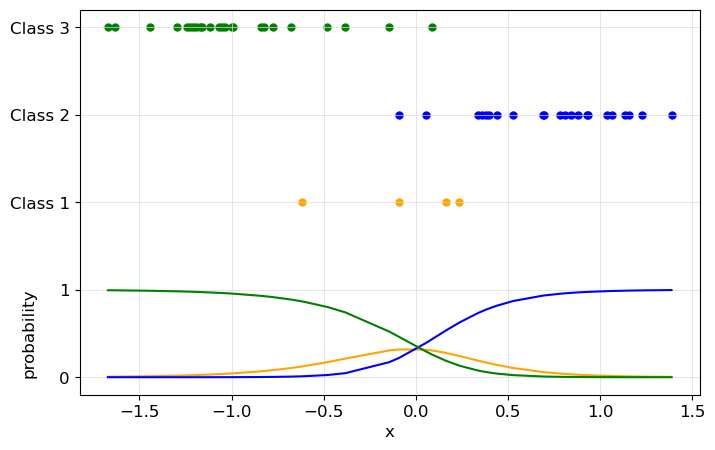

In [73]:
plt.figure(figsize=(8, 5))
ax = plt.subplot(1, 1, 1)
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('probability', fontsize=12)
ax.yaxis.set_label_coords(-0.07, 0.16)

ax.set_yticks([0,1,2,3,4])
ax.set_yticklabels(['0','1','Class 1', 'Class 2', 'Class 3'])

ax.plot(xobs, p1, c="orange")
ax.plot(xobs, p2, c="blue")
ax.plot(xobs, p3, c="green")

class1 = observed_class == 0
ax.scatter(xobs[class1], observed_class[class1]+2, c="orange", s=25)
class2 = observed_class == 1
ax.scatter(xobs[class2], observed_class[class2]+2, c="blue", s=25)
class3 = observed_class == 2
ax.scatter(xobs[class3], observed_class[class3]+2, c="green", s=25)

plt.show()

The probability curves are the true (but unknown) ones that we used to generate this synthetic dataset.

Our UltraNest model looks as follows:

In [74]:
def my_prior_transform(cube):
    params = cube.copy()
    params[0] = sp.stats.norm.ppf(cube[0], 0, 10)                              # intercept2
    params[1] = sp.stats.norm.ppf(cube[1], 0, 10)                              # slope2
    params[2] = sp.stats.norm.ppf(cube[2], 0, 10)                              # intercept3
    params[3] = sp.stats.norm.ppf(cube[3], 0, 10)                              # slope3
    return params


def my_loglikelihood(params):
    intercept2, slope2, intercept3, slope3 = params

    exp2 = np.exp(intercept2+slope2*xobs)
    exp3 = np.exp(intercept3+slope3*xobs)
    p1 = 1.0 / (1.0 + exp2+exp3)
    p2 = exp2 * p1
    p3 = exp3 * p1
    p = np.transpose([p1,p2,p3])
    loglike = sp.stats.multinomial.logpmf(yobs, n=1, p=p).sum()                         # Discrete distributions have a pmf() rather than a pdf()
    return loglike

In [75]:
param_names = ["intercept2", "slope2", "intercept3", "slope3"]
sampler = ultranest.ReactiveNestedSampler(param_names, my_loglikelihood, my_prior_transform)
results = sampler.run()
sampler.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-12.8877..-12.8876]*| it/evals=5160/12334 eff=43.2378% N=400  
[ultranest] Likelihood function evaluations: 12399
[ultranest]   logZ = -21.24 +- 0.07996
[ultranest] Effective samples strategy satisfied (ESS = 2078.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.08, need <0.5)
[ultranest]   logZ error budget: single: 0.13 bs:0.08 tail:0.01 total:0.08 required:<0.50
[ultranest] done iterating.

logZ = -21.221 +- 0.152
  single instance: logZ = -21.221 +- 0.128
  bootstrapped   : logZ = -21.236 +- 0.151
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    intercept2          : -7.1  │ ▁    ▁ ▁▁▁▁▁▁▁▁▁▁▂▃▄▅▆▆▇▇▇▅▄▃▂▁▁▁▁▁▁▁ │3.7       -0.3 +- 1.0
    slope2              : -1.0  │ ▁▁▁▁▂▄▆▆▆▇▇▇▇▇▄▅▃▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁ ▁▁ │24.1      7.5 +- 3.2
    intercept3          : -5.70 │ ▁ ▁▁▁▁▁

In [76]:
mean_intercept2 = np.mean(results["samples"][:,0])
mean_slope2 = np.mean(results["samples"][:,1])
mean_intercept3 = np.mean(results["samples"][:,2])
mean_slope3 = np.mean(results["samples"][:,3])

xvalues = np.linspace(-1.7, 1.5, 100)
exp2 = np.exp(mean_intercept2 + mean_slope2 * xvalues)
exp3 = np.exp(mean_intercept3 + mean_slope3 * xvalues)
mean_p1 = 1.0 / (1.0 + exp2+exp3)
mean_p2 = exp2 * mean_p1
mean_p3 = exp3 * mean_p1


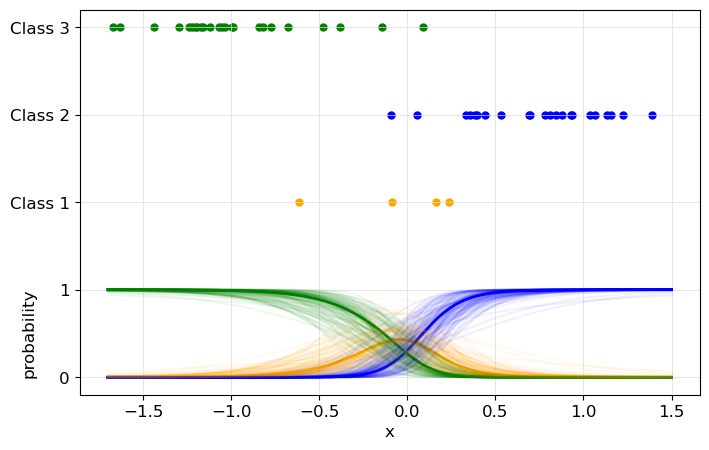

In [77]:
plt.figure(figsize=(8, 5))
ax = plt.subplot(1, 1, 1)
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('probability', fontsize=12)
ax.yaxis.set_label_coords(-0.07, 0.16)
ax.set_yticks([0,1,2,3,4])
ax.set_yticklabels(['0','1','Class 1', 'Class 2', 'Class 3'])

# Plot the probability curves using the mean posterior values for (p1,p2,p3)

ax.plot(xvalues, mean_p1, c="orange", linewidth=2)
ax.plot(xvalues, mean_p2, c="blue",   linewidth=2)
ax.plot(xvalues, mean_p3, c="green",  linewidth=2)

# For each of the p_j, plot 100 randomly chosen samples from the posterior
# This gives us a good idea about the uncertainties involved.

for n in range(100):
    intercept2 = results["samples"][10+10*n, 0]
    slope2     = results["samples"][10+10*n, 1]
    intercept3 = results["samples"][10+10*n, 2]
    slope3     = results["samples"][10+10*n, 3]
    xvalues = np.linspace(-1.7, 1.5, 100)
    exp2 = np.exp(intercept2 + slope2 * xvalues)
    exp3 = np.exp(intercept3 + slope3 * xvalues)
    p1 = 1.0 / (1.0 + exp2+exp3)
    p2 = exp2 * p1
    p3 = exp3 * p1
    ax.plot(xvalues, p1, c="orange", alpha=0.06)
    ax.plot(xvalues, p2, c="blue",   alpha=0.06)
    ax.plot(xvalues, p3, c="green",  alpha=0.06)

# Plot the observed data using the same colors

class1 = observed_class == 0
ax.scatter(xobs[class1], observed_class[class1]+2, c="orange", s=25)
class2 = observed_class == 1
ax.scatter(xobs[class2], observed_class[class2]+2, c="blue", s=25)
class3 = observed_class == 2
ax.scatter(xobs[class3], observed_class[class3]+2, c="green", s=25)

Back to [contents](#Contents).

---

## Modeling a fraction with the Beta distribution with UltraNest

In [78]:
url = "https://raw.githubusercontent.com/JorisDeRidder/DataAnalysisInPhysicsAndAstronomy/main/Datasets/f_gas.csv"
data = pd.read_csv(url, comment='#')
data.head()

,NSAID,RA,DEC,DISTANCE,DISTANCE_ERR,INCLINATION,V_W20I,V_W20I_ERR,R_EFF,R_EFF_ERR,M_HI,M_HI_ERR,M_STAR,M_STAR_ERR,SOURCE
0,162,09:58:30.23,+00:02:42.72,30.230679,1.893556,71,40.484997,3.175172,0.718135,0.044982,1.051982e+08,29240232.0,16153380.0,7440246.5,1
1,1443,12:23:09.98,+00:25:37.76,35.361080,2.000777,68,26.163080,13.456303,0.863503,0.048858,4.139277e+07,18685420.0,43087828.0,19846254.0,1
2,5109,22:30:36.80,-00:06:37.01,21.256725,1.857816,28,77.564659,3.161093,0.285932,0.024990,6.664611e+07,24189620.0,7706057.5,3549410.0,3
3,5378,23:06:39.16,+00:34:41.02,68.131355,2.393957,70,61.939968,2.134023,1.818062,0.063882,1.039202e+09,166114256.0,273271296.0,125868760.0,1
4,5424,23:14:19.43,+00:10:59.36,60.297279,1.750601,88,63.627235,3.002364,1.771058,0.051419,4.048609e+08,58240672.0,611754560.0,281774176.0,1


In [79]:
xobs = np.log10(data['M_STAR'].values)
yobs = data['M_HI'].values / (data['M_HI'].values + data['M_STAR'].values)               # gas fraction

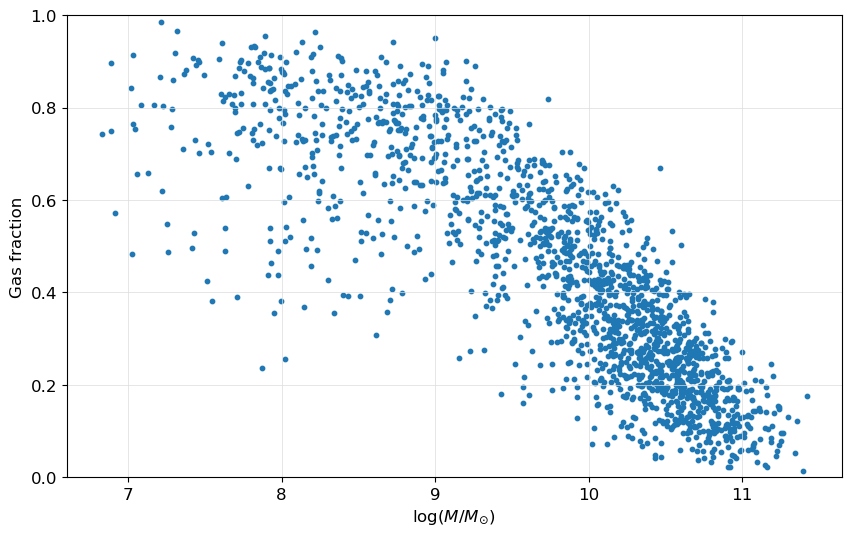

In [80]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.scatter(xobs, yobs, s=10)
ax.set_ylabel("Gas fraction")
ax.set_xlabel(r"$\log(M/M_{\odot})$")
ax.set_ylim(0,1)
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

The UltraNest model. Note that the `sp.stats.beta.logpdf` is quickly suffering from numerical problems. The prior on the slope was therefore taken fairly narrow.

In [81]:
def my_prior_transform(cube):
    params = cube.copy()
    params[0] = sp.stats.uniform.ppf(cube[0], -20, 40)                              # intercept
    params[1] = sp.stats.uniform.ppf(cube[1], -1, 2)                                # slope
    params[2] = sp.stats.uniform.ppf(cube[2], 0, 20)                                # kappa
    return params


def my_loglikelihood(params):
    intercept, slope, kappa = params
    mu = expit(intercept + slope * xobs)
    alpha = mu * kappa
    beta = (1-mu) * kappa
    loglike = sp.stats.beta.logpdf(yobs, alpha, beta).sum()
    return loglike

In [82]:
param_names = ["intercept", "slope", "kappa"]
sampler = ultranest.ReactiveNestedSampler(param_names, my_loglikelihood, my_prior_transform)
results = sampler.run()
sampler.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=1e+03  6.98 [1166.9241..1166.9241]*| it/evals=7320/13436 eff=56.1522% N=400   0  
[ultranest] Likelihood function evaluations: 13438
[ultranest]   logZ = 1153 +- 0.1441
[ultranest] Effective samples strategy satisfied (ESS = 1777.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.

logZ = 1153.244 +- 0.366
  single instance: logZ = 1153.244 +- 0.176
  bootstrapped   : logZ = 1153.277 +- 0.366
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    intercept           : 8.55  │ ▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▄▄▄▆▅▇▇▆▇▆▇▇▆▄▅▄▄▃▂▁▁ │9.61      9.22 +- 0.16
    slope               : -1.000│▂▃▃▄▅▄▅▆▇▇▆▇▆▇▇▆▅▅▄▄▄▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁ │-0.900    -0.969 +- 0.016
    kappa               : 

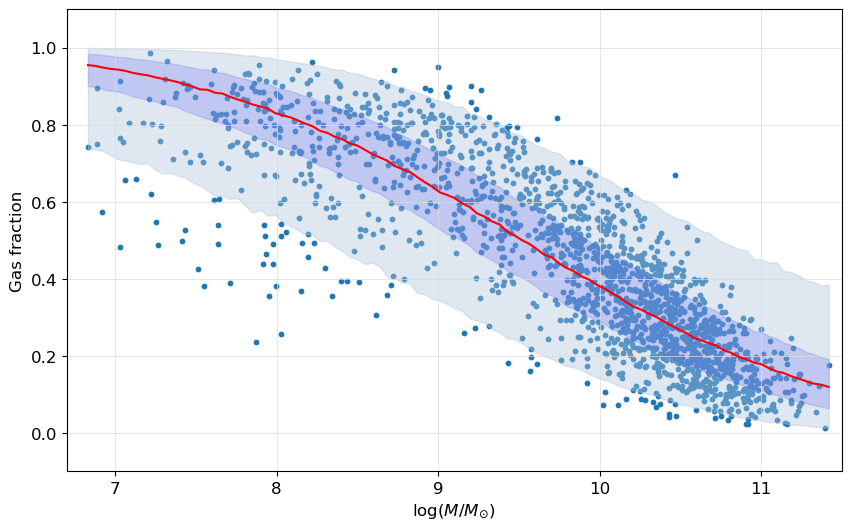

In [83]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.scatter(xobs, yobs, s=10)

xnew = np.linspace(xobs.min(), xobs.max(), 100)
band = PredictionBand(xnew)
for intercept, slope, kappa in sampler.results['samples']:
    mu = expit(intercept + slope * xnew)
    alpha = mu * kappa
    beta = (1-mu) * kappa
    ynew = sp.stats.beta.rvs(alpha, beta)
    band.add(ynew)

band.line(color='r')                                              # The mean of the posterior 
band.shade(q=0.25, color='blue', alpha=0.2)                       # The 50%-region
band.shade(q=0.475, color='lightsteelblue', alpha=0.4)            # Shade the region between 0.5-q and 0.5+q quantiles

ax.set_ylabel("Gas fraction")
ax.set_xlabel(r"$\log(M/M_{\odot})$")
ax.set_ylim(-0.1, 1.1)
ax.set_xlim(6.7, 11.5)
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

Back to [contents](#Contents).

---

## Modeling counts with Poisson with UltraNest

In [92]:
url = "https://raw.githubusercontent.com/JorisDeRidder/DataAnalysisInPhysicsAndAstronomy/main/Datasets/GCs.csv"
data = pd.read_csv(url, comment='#')
data.head()

,N_GC,MV_T,Type
0,160,-21.30,S
1,1,-14.84,Irr
2,150,-20.18,S
3,36,-18.77,S
4,10,-15.46,E


In [93]:
xobs = data['MV_T']
yobs = data['N_GC']

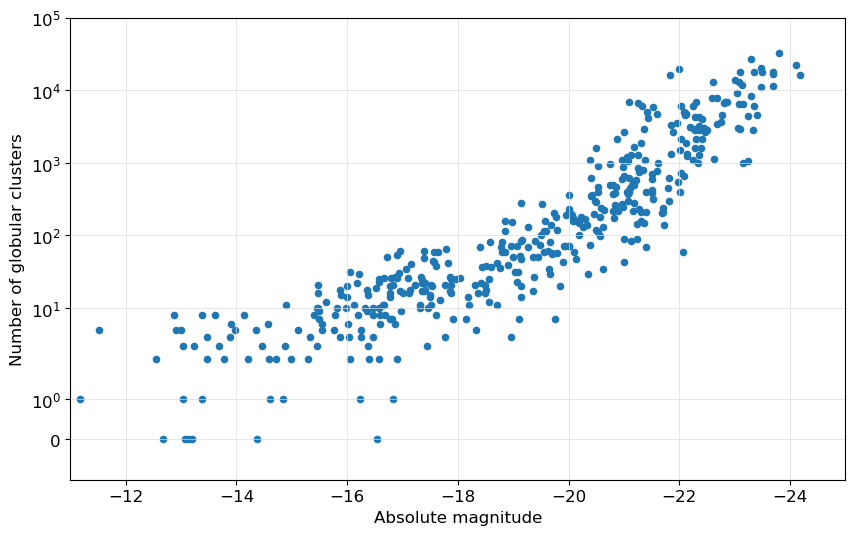

In [94]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.scatter(xobs, yobs, s=20)
ax.set_xlabel("Absolute magnitude")
ax.set_ylabel("Number of globular clusters")
ax.set_xlim(-11,-25.)
ax.set_ylim(-1, 10**5)
ax.set_yscale('symlog')
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

The UltraNest model:

In [97]:
def my_prior_transform(cube):
    params = cube.copy()
    params[0] = sp.stats.norm.ppf(cube[0], 0, 5)                                   # intercept
    params[1] = sp.stats.norm.ppf(cube[1], 0, 5)                                   # slope
    return params


def my_loglikelihood(params):
    intercept, slope = params
    mu = np.exp(intercept + slope * xobs)
    loglike = sp.stats.poisson.logpmf(yobs, mu).sum()
    return loglike

In [98]:
param_names = ["intercept", "slope"]
sampler = ultranest.ReactiveNestedSampler(param_names, my_loglikelihood, my_prior_transform)
results = sampler.run()
sampler.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+05  ..-199244.36 [-199244.6321..-199244.6318]*| it/evals=13280/22644 eff=59.7015% N=400   0 
[ultranest] Likelihood function evaluations: 22670
[ultranest]   logZ = -1.993e+05 +- 0.1871
[ultranest] Effective samples strategy satisfied (ESS = 2023.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.19, need <0.5)
[ultranest]   logZ error budget: single: 0.26 bs:0.19 tail:0.01 total:0.19 required:<0.50
[ultranest] done iterating.

logZ = -199273.166 +- 0.475
  single instance: logZ = -199273.166 +- 0.257
  bootstrapped   : logZ = -199273.185 +- 0.475
  tail           : logZ = +- 0.010
insert order U test : converged: False correlation: 16 iterations

    intercept           : -15.8863│ ▁▁▁▂▄▅▇▇▅▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁    ▁ │-15.8487    -15.8775 +- 0.0033
    slope               : -1.07913│ ▁▁▁▁▇▇▆▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁   ▁ │-1.07761  

In [99]:
meanIntercept = results['samples'][:,0].mean()
meanSlope = results['samples'][:,1].mean()

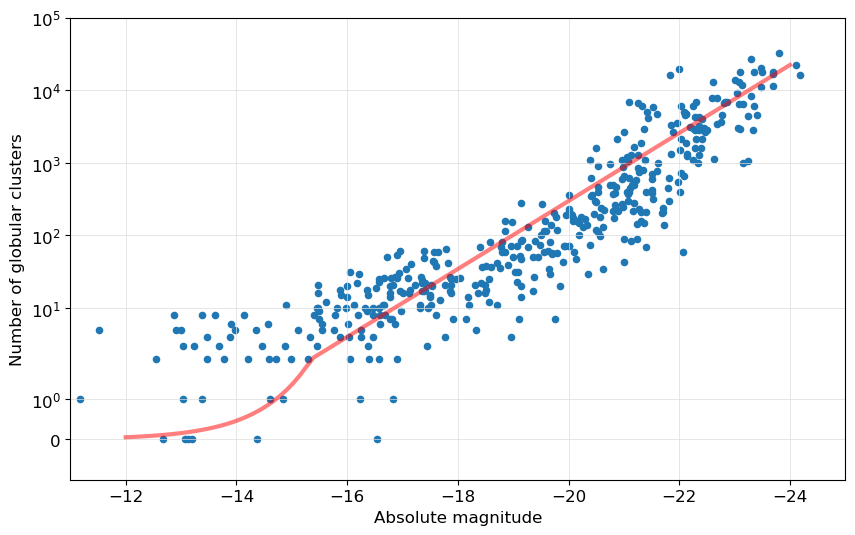

In [100]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.scatter(xobs, yobs, s=20)

xvalues = np.linspace(-24, -12, 100)
yvalues = np.exp(meanIntercept + meanSlope * xvalues)
ax.plot(xvalues, yvalues, c="red", linewidth=3, alpha=0.5)

ax.set_xlabel("Absolute magnitude")
ax.set_ylabel("Number of globular clusters")
ax.set_xlim(-11,-25.)
ax.set_ylim(-1.0, 10**5)
ax.set_yscale('symlog')
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

The odd appearance of the mean response is due to the choice of "symlog" for the y-axis scale.

Back to [contents](#Contents).

---

## A zero-truncated Poisson model with UltraNest

Create an artificial dataset:

In [89]:
y = sp.stats.poisson.rvs(mu=2.5, size=200)
y = y + 1                                                     # No zeros in our dataset 

In [90]:
def my_prior_transform(cube):
    params = cube.copy()
    params[0] = sp.stats.halfcauchy.ppf(cube[0], 0, 5)                                    # mu
    return params


def my_loglikelihood(params):
    mu = params[0]
    loglike = (sp.stats.poisson.logpmf(y, mu) - np.log(1-np.exp(-mu))).sum()
    return loglike

In [91]:
param_names = ["mu"]
sampler = ultranest.ReactiveNestedSampler(param_names, my_loglikelihood, my_prior_transform)
results = sampler.run()
sampler.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-4e+02  .53 [-359.5354..-359.5354]*| it/evals=2800/3288 eff=96.9529% N=400 0 
[ultranest] Likelihood function evaluations: 3291
[ultranest]   logZ = -363.1 +- 0.07925
[ultranest] Effective samples strategy satisfied (ESS = 1254.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.09 bs:0.08 tail:0.03 total:0.09 required:<0.50
[ultranest] done iterating.

logZ = -363.081 +- 0.134
  single instance: logZ = -363.081 +- 0.088
  bootstrapped   : logZ = -363.082 +- 0.130
  tail           : logZ = +- 0.031
insert order U test : converged: True correlation: inf iterations

    mu                  : 2.88  │ ▁▁▁▁▁▁▁▂▂▂▄▄▅▆▆▇▆▇▇▄▅▄▅▂▂▂▁▁▁▁▁▁▁▁▁ ▁ │3.96      3.37 +- 0.14



Back to [contents](#Contents).

---

## Bayesian Model Comparison

### Generate the artificial dataset

In [49]:
rng = np.random.default_rng(14)
N = 200
x = np.linspace(0, 10, N)
y1 = 0.07 * x                                      # background
y2 = 3 / ((x-4.)**2 + (0.5*1.5)**2)                # lorentz profile #1
y3 =  2 / ((x-5.2)**2 + (0.5*2)**2)                # lorentz profile #2
y = y1 + y2 + y3 + rng.normal(0.0, 0.5, N)

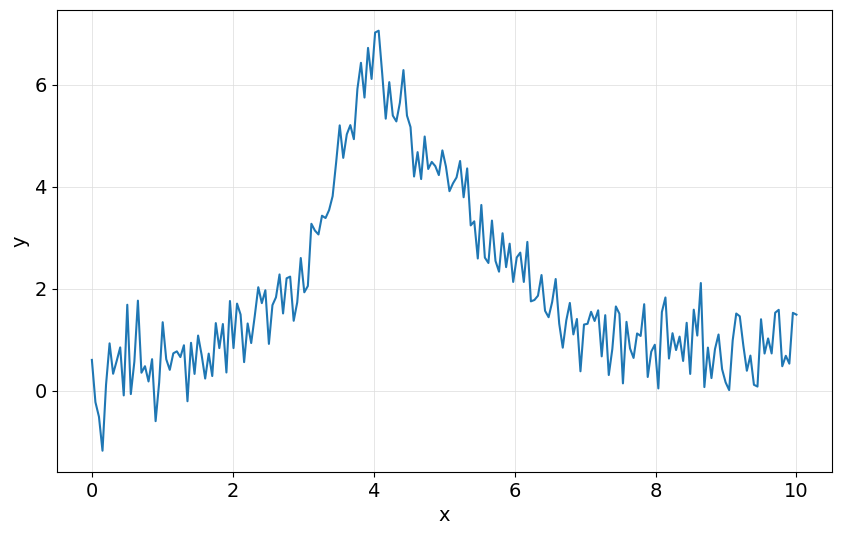

In [56]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.plot(x, y)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

### The question

For our dataset, are we dealing with:

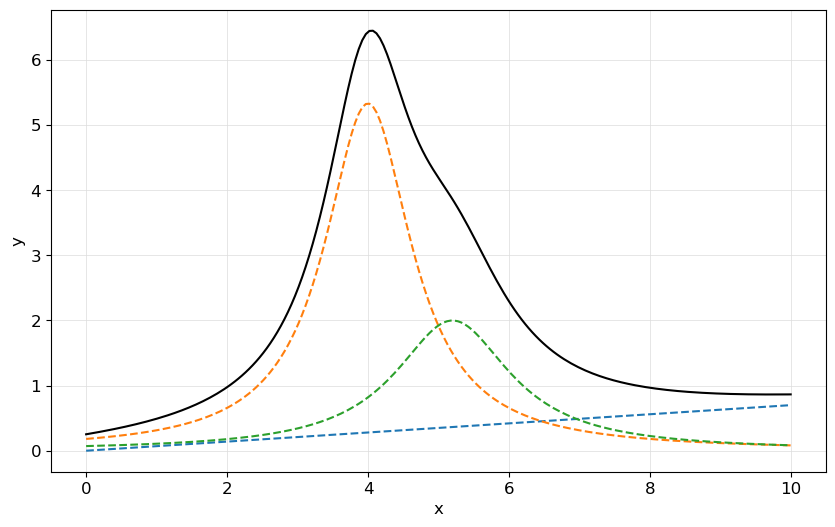

In [54]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.plot(x, y1, linestyle="--")
ax.plot(x, y2, linestyle="--")
ax.plot(x, y3, linestyle="--")
ax.plot(x, y1+y2+y3, c="k")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

or with:

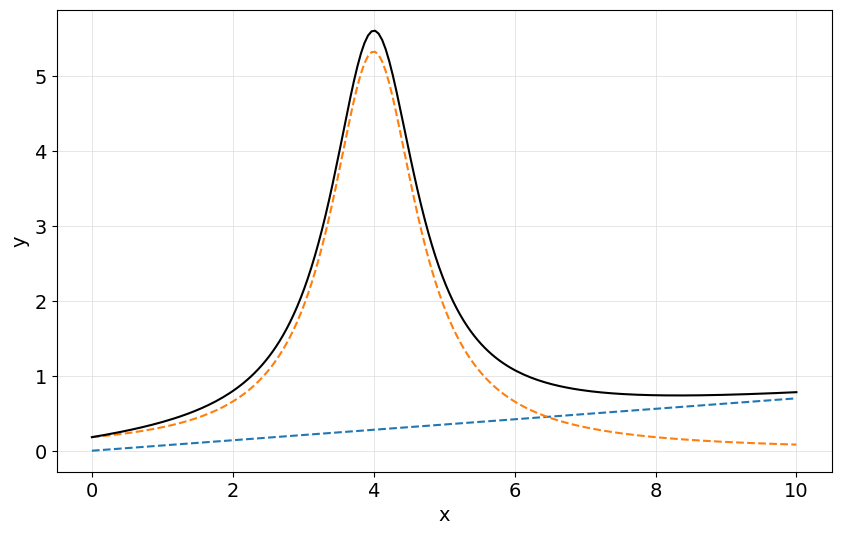

In [57]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.plot(x, y1, linestyle="--")
ax.plot(x, y2, linestyle="--")
ax.plot(x, y1+y2, c="k")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

### Modeling the two-component model with UltraNest

In [103]:
def my_prior_transform(cube):
    params = cube.copy()
    params[0] = sp.stats.halfnorm.ppf(cube[0], 0, 1)                                      # slope of the background
    params[1] = sp.stats.norm.ppf(cube[1], 4.0, 2.0)                                      # position of the main Lorentz profile
    params[2] = sp.stats.halfnorm.ppf(cube[2], 0, 1)                                      # width of the main Lorentz profile
    params[3] = sp.stats.halfnorm.ppf(cube[3], 3, 2)                                      # amplitude of the main Lorentz profile
    params[4] = sp.stats.halfnorm.ppf(cube[4], 0, 1)                                      # stdev of the noise
    return params


def my_loglikelihood(params):
    slope, x0, width, ampl, sigma = params
    mu = slope * x + ampl / ((x-x0)**2 + (0.5 * width)**2) 
    loglike = sp.stats.norm.logpdf(y, mu, sigma).sum()
    return loglike

In [104]:
param_names = ["slope", "x0", "width", "ampl", "sigma"]
sampler = ultranest.ReactiveNestedSampler(param_names, my_loglikelihood, my_prior_transform)
results = sampler.run()
sampler.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+02  .02 [-166.2741..-166.2738]*| it/evals=9480/44162 eff=21.6626% N=400   0  0 
[ultranest] Likelihood function evaluations: 44185
[ultranest]   logZ = -185.3 +- 0.1715
[ultranest] Effective samples strategy satisfied (ESS = 2479.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.17, need <0.5)
[ultranest]   logZ error budget: single: 0.20 bs:0.17 tail:0.01 total:0.17 required:<0.50
[ultranest] done iterating.

logZ = -185.306 +- 0.363
  single instance: logZ = -185.306 +- 0.204
  bootstrapped   : logZ = -185.300 +- 0.363
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    slope               : 0.0344│ ▁ ▁▁▁▁▁▁▁▁▂▃▃▄▄▆▆▆▇▇▆▅▅▄▄▃▂▂▁▁▁▁▁▁▁▁▁ │0.1130    0.0738 +- 0.0096
    x0                  : 4.116 │ ▁▁▁▁▁▁▁▁▂▃▃▄▅▅▆▇▇▇▇▇▅▄▄▃▃▂▁▁▁▁▁▁▁▁▁ ▁ │4.347     4.223 +- 0.028
    width          

In [105]:
logEvidence1 = results["logz"]
print("log(Z) = ", logEvidence1)

log(Z) =  -185.3061293175938


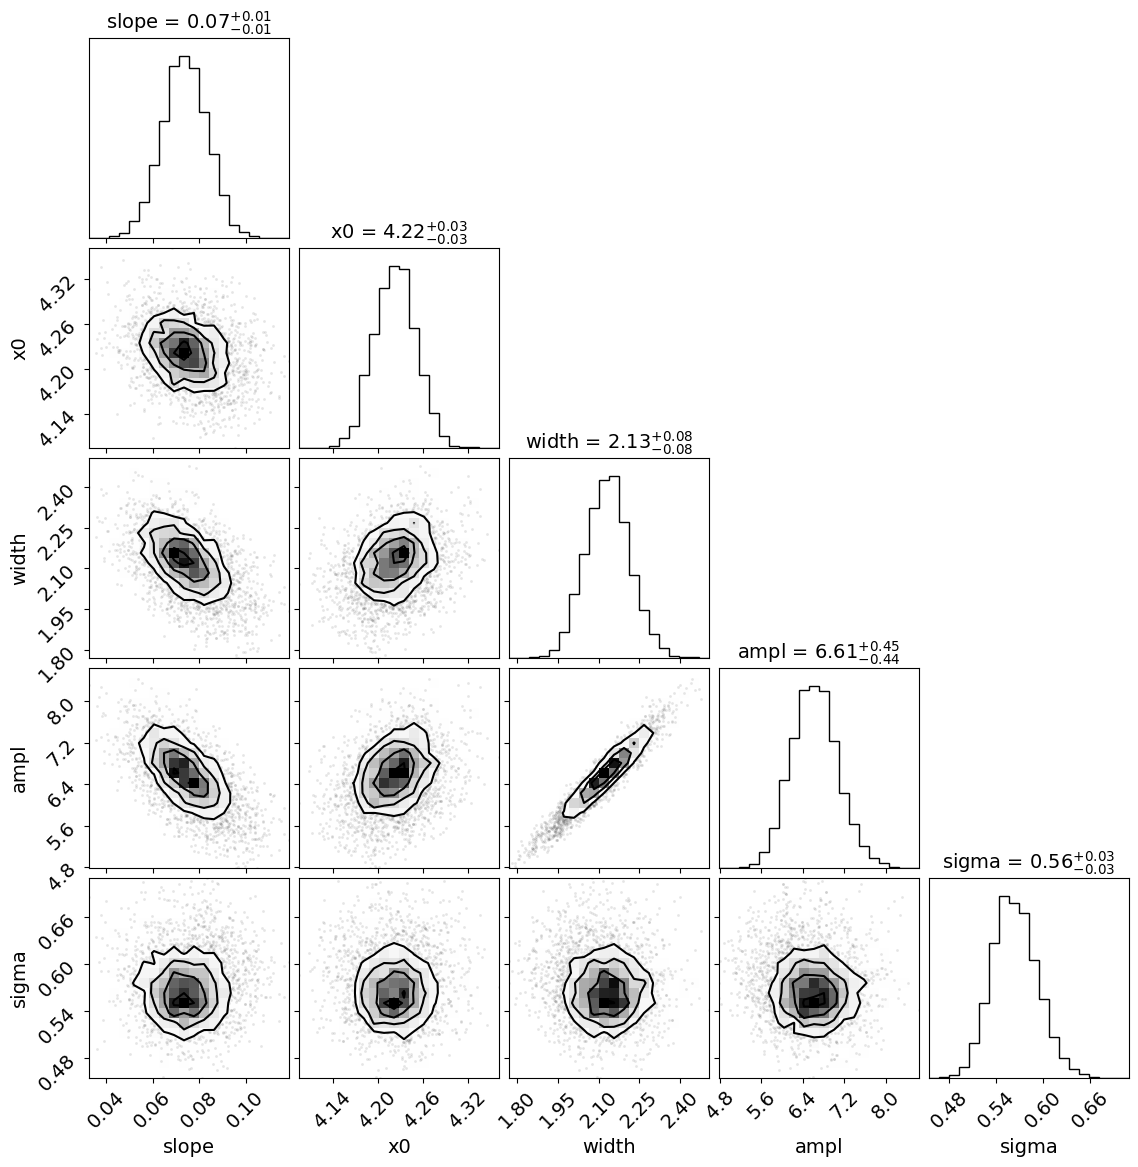

In [106]:
cornerplot(results)

Plotting the mean of the posterior

In [107]:
meanSlope, meanX0, meanWidth, meanAmpl, meanSigma  = results['posterior']['mean']
meanResponse =  meanSlope * x + meanAmpl / ((x-meanX0)**2 + (0.5*meanWidth)**2)

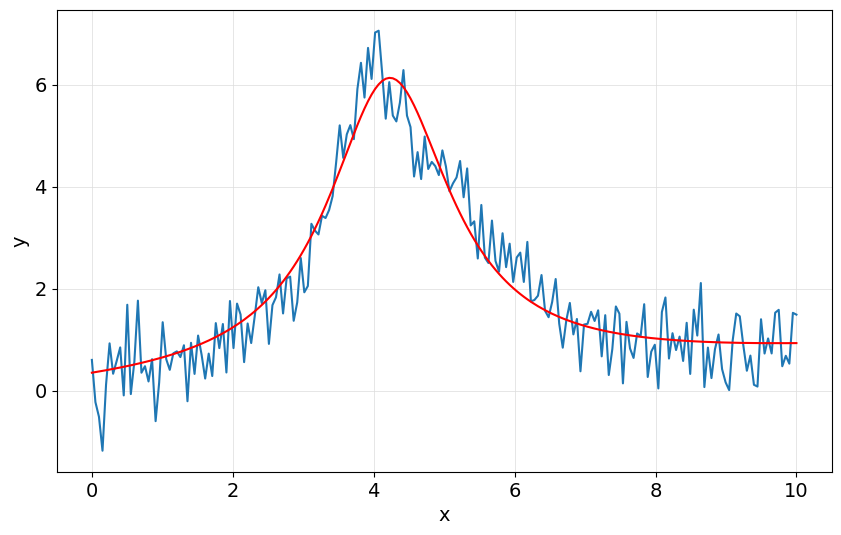

In [108]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.plot(x, y)
ax.plot(x, meanResponse, c="red")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

### Modeling the three-component model with UltraNest

In [117]:
def my_prior_transform(cube):
    params = cube.copy()
    params[0] = sp.stats.halfnorm.ppf(cube[0], 0, 1)                                    # slope of the background
    params[1] = sp.stats.norm.ppf(cube[1], 4.0, 2.0)                                    # position of the main Lorentz profile
    params[2] = sp.stats.halfnorm.ppf(cube[2], 0, 1)                                    # width of the main Lorentz profile
    params[3] = sp.stats.halfnorm.ppf(cube[3], 1, 3)                                    # amplitude of the main Lorentz profile
    params[4] = sp.stats.halfnorm.ppf(cube[4], 0.5, 1)                                  # separation between main and secondary Lorentz profile
    params[5] = sp.stats.halfnorm.ppf(cube[5], 0, 2)                                    # width of the secondary Lorentz profile
    params[6] = sp.stats.halfnorm.ppf(cube[6], 0.1, 3)                                  # amplitude of the secondary Lorentz profile
    params[7] = sp.stats.halfnorm.ppf(cube[7], 0, 1)                                    # stdev of the noise
    return params


def my_loglikelihood(params):
    slope, x0, width1, ampl1, separation, width2, ampl2, sigma = params
    mu = slope * x + ampl1 / ((x-x0)**2 + (0.5 * width1)**2) + ampl2 / ((x-(x0+separation))**2 + (0.5 * width2)**2)
    loglike = sp.stats.norm.logpdf(y, mu, sigma).sum()
    return loglike

In [118]:
param_names = ["slope", "x0", "width1", "ampl1", "separation", "width2", "ampl2", "sigma"]
sampler = ultranest.ReactiveNestedSampler(param_names, my_loglikelihood, my_prior_transform)
results = sampler.run()
sampler.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+02  .05 [-139.6199..-139.6199]*| it/evals=11400/656172 eff=1.7384% N=400  0  0 
[ultranest] Likelihood function evaluations: 656172
[ultranest]   logZ = -163.3 +- 0.1308
[ultranest] Effective samples strategy satisfied (ESS = 2877.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.23 bs:0.13 tail:0.01 total:0.13 required:<0.50
[ultranest] done iterating.

logZ = -163.348 +- 0.381
  single instance: logZ = -163.348 +- 0.227
  bootstrapped   : logZ = -163.316 +- 0.381
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    slope               : 0.020 │ ▁▁▁▁▁▁▁▁▁▂▂▄▄▄▆▇▇▇▇▆▇▆▅▄▃▂▁▁▁▁▁▁▁   ▁ │0.112     0.064 +- 0.011
    x0                  : 3.782 │ ▁ ▁▁▁▁▁▁▁▁▃▃▄▄▅▆▇▇▇▆▇▆▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁ │4.121     3.948 +- 0.040
    width1          

In [121]:
logEvidence2 = results["logz"]
print("log(Z) = ", logEvidence2)

log(Z) =  -163.348471267537


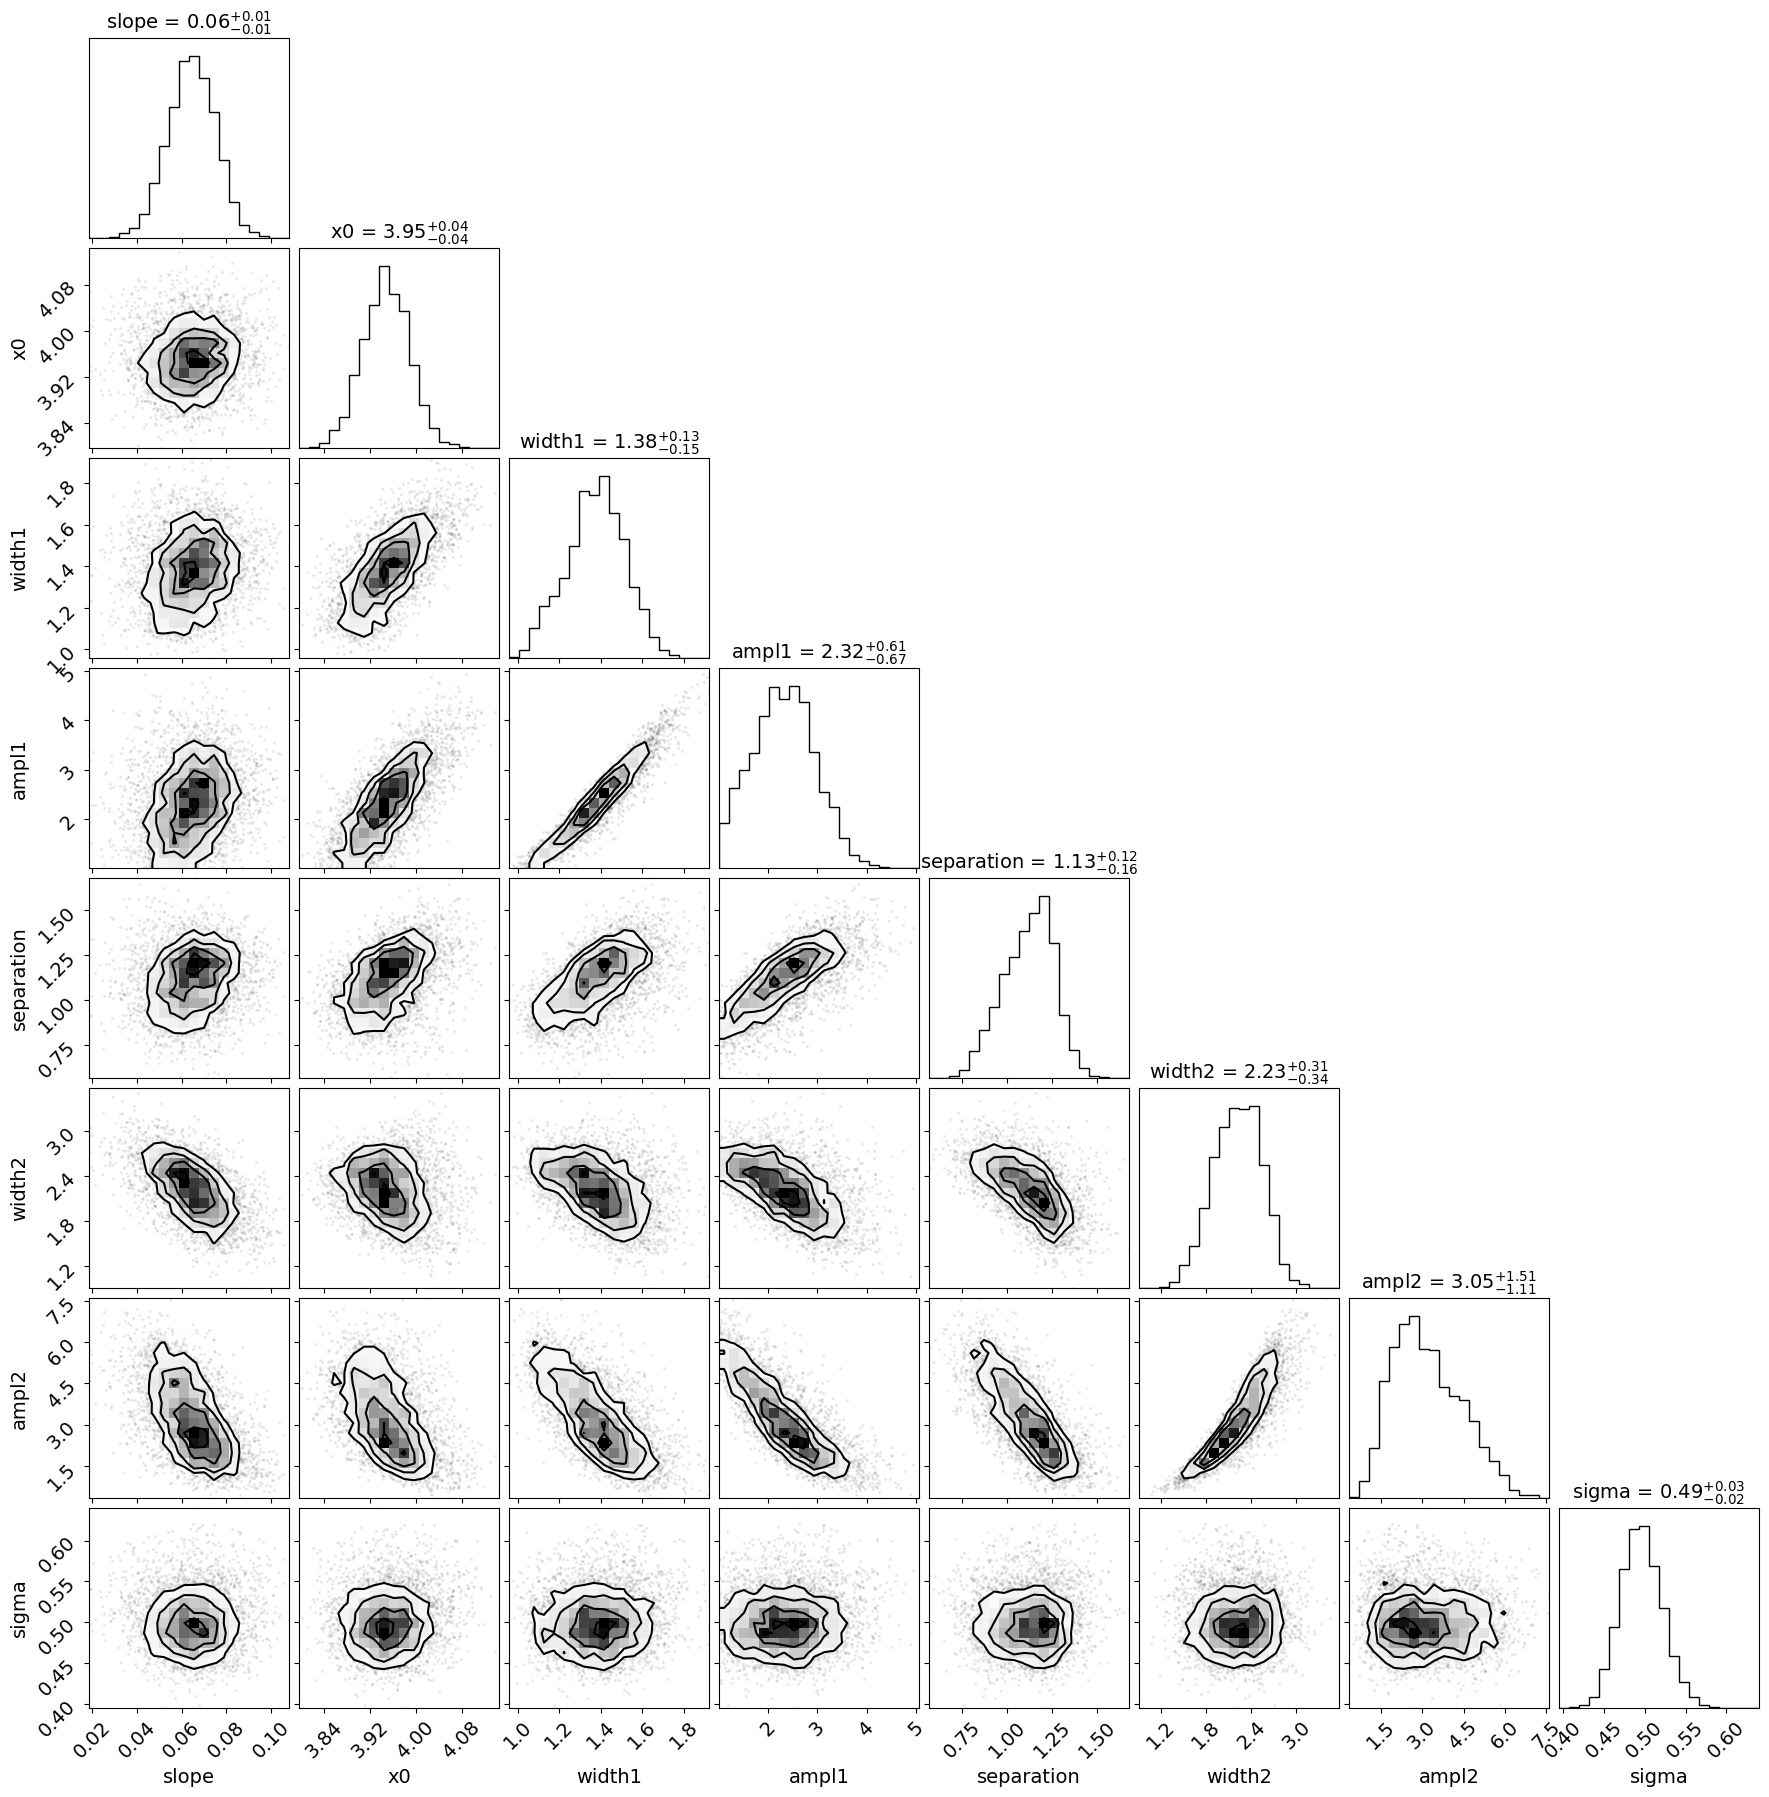

In [122]:
cornerplot(results)

In [123]:
meanSlope, meanX0, meanWidth1, meanAmpl1, meanSep, meanWidth2, meanAmpl2, meanSigma  = results['posterior']['mean']
meanResponse =  meanSlope * x + meanAmpl1 / ((x-meanX0)**2 + (0.5*meanWidth1)**2) + meanAmpl2 / ((x-(meanX0+meanSep))**2 + (0.5*meanWidth2)**2)

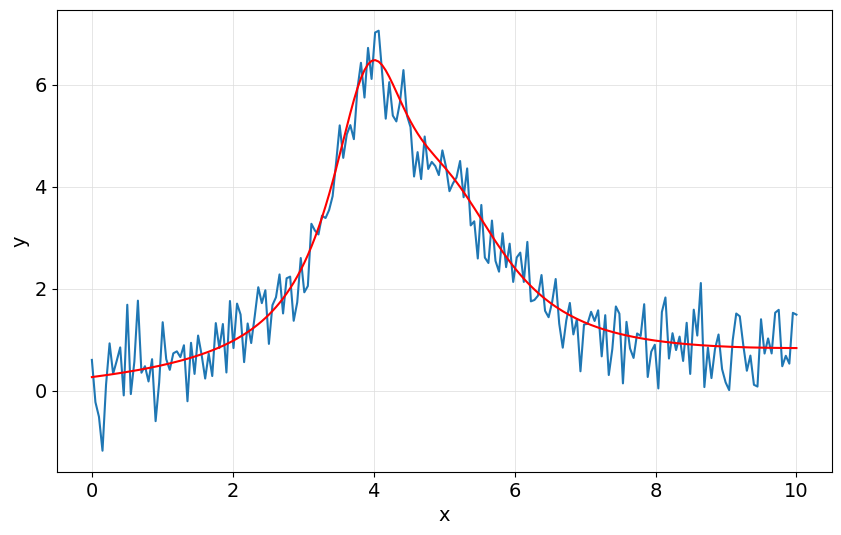

In [124]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.plot(x, y)
ax.plot(x, meanResponse, c="red")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

### Comparison between the two models

In [125]:
priorRatio = 1.0                                                     # No reason to a priori prefer one model over the other
BayesFactor = np.exp(logEvidence1 - logEvidence2)
posteriorRatio = BayesFactor * priorRatio

print("Posterior ratio P(M1 | D) / P(M2 | D) = ", posteriorRatio)

Posterior ratio P(M1 | D) / P(M2 | D) =  2.9101158165224645e-10


This implies that there is decisive evidence that model 2 is to be preferred above model 1. 